<a class="anchor" id="0"></a>

# Automatic selection from 20 classifier models on the example of competition "Titanic: Machine Learning from Disaster"

**Automatic selection of binary classification models** works as follows (methodology worked out on the my kernel with 15 regression models - [Suspended substances prediction in river](https://www.kaggle.com/vbmokin/suspended-substances-prediction-in-river)) - a training dataset (on the given *path* to files) with a target column is divided into training and "test" (*test_train_split_part* = 0.2: train/test => 80/20% default). Models are built on the training set and are tested on a "test" set - which they give a match on given metrics (default metrics: *r2-score*, *relative error* and *rmse* but you can only select some from them). The user chooses which metric is the main one (*metric_main*) - it selects the *N_best_models* amount of most accurate models for this metric. 
Next, kernel automatic rebuild these the best of models on a full (100%) training dataset and apply to a true test file and generate *N_best_models* submission files.

Each model is built using cross-validation (except LGBM). The parameters of the model are selected to ensure the maximum matching of accuracy on the training and validation data. A plot is being built for this purpose with **learning_curve** from sklearn library.

**NEW: I created additional double features in different combinations to find new patterns**

This kernel is based on the kernels:

* [Suspended substances prediction in river](https://www.kaggle.com/vbmokin/suspended-substances-prediction-in-river)

* [Titanic (0.83253) - Comparison 20 popular models](https://www.kaggle.com/vbmokin/titanic-0-83253-comparison-20-popular-models)

* [Titanic: random forest](https://www.kaggle.com/morenovanton/titanic-random-forest)

<a class="anchor" id="0.1"></a>

## Table of Contents

1. [Import libraries](#1)
1. [Download datasets](#2)
1. [FE&EDA](#3)
1. [Preparing to modeling](#4)
1. [Tuning models with GridSearchCV](#5)
    -  [Linear Regression](#5.1)
    -  [Support Vector Machines](#5.2)
    -  [Linear SVC](#5.3)
    -  [MLP Classifier](#5.4)
    -  [Stochastic Gradient Descent](#5.5)
    -  [Decision Tree Classifier](#5.6)
    -  [Random Forest](#5.7)
    -  [XGB Classifier](#5.8)
    -  [LGBM Classifier](#5.9)
    -  [Gradient Boosting Classifier](#5.10)
    -  [Ridge Classifier](#5.11)
    -  [Bagging Classifier](#5.12)
    -  [Extra Trees Classifier](#5.13)
    -  [AdaBoost Classifier](#5.14)
    -  [Logistic Regression](#5.15)
    -  [k-Nearest Neighbors (KNN)](#5.16)
    -  [Naive Bayes](#5.17)
    -  [Perceptron](#5.18)
    -  [Gaussian Process Classification](#5.19)
    -  [Voting Classifier](#5.20)    
1. [Models comparison](#6)
1. [Prediction](#7)

## 1. Import libraries <a class="anchor" id="1"></a>

[Back to Table of Contents](#0.1)

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve, ShuffleSplit
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score

# models
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier 
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

## 2. Download datasets <a class="anchor" id="2"></a>

[Back to Table of Contents](#0.1)

In [2]:
path = "../input/titanic/"

In [3]:
cv_n_split = 2
random_state = 0
test_train_split_part = 0.15

In [4]:
metrics_all = {1 : 'r2_score', 2: 'acc', 3 : 'rmse', 4 : 're'}
metrics_now = [1, 2, 3, 4] # you can only select some numbers of metrics from metrics_all

In [5]:
traindf = pd.read_csv(path + 'train.csv').set_index('PassengerId')
testdf = pd.read_csv(path + 'test.csv').set_index('PassengerId')
submission = pd.read_csv(path + 'gender_submission.csv')

In [6]:
traindf.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [7]:
target_name = 'Survived'

In [8]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [9]:
testdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


## 3. FE&EDA <a class="anchor" id="3"></a>

[Back to Table of Contents](#0.1)

**FE based on the my kernel [Autoselection from 20 classifier models & L_curves](https://www.kaggle.com/vbmokin/autoselection-from-20-classifier-models-l-curves)**

In [10]:
#Thanks to:
# https://www.kaggle.com/mauricef/titanic
# https://www.kaggle.com/vbmokin/titanic-top-3-one-line-of-the-prediction-code

df = pd.concat([traindf, testdf], axis=0, sort=False)
df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
df['IsWomanOrBoy'] = ((df.Title == 'Master') | (df.Sex == 'female'))
df['LastName'] = df.Name.str.split(',').str[0]
family = df.groupby(df.LastName).Survived
df['WomanOrBoyCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).count())
df['WomanOrBoyCount'] = df.mask(df.IsWomanOrBoy, df.WomanOrBoyCount - 1, axis=0)
df['FamilySurvivedCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).sum())
df['FamilySurvivedCount'] = df.mask(df.IsWomanOrBoy, df.FamilySurvivedCount - \
                                    df.Survived.fillna(0), axis=0)
df['WomanOrBoySurvived'] = df.FamilySurvivedCount / df.WomanOrBoyCount.replace(0, np.nan)
df.WomanOrBoyCount = df.WomanOrBoyCount.replace(np.nan, 0)
df['Alone'] = (df.WomanOrBoyCount == 0)

In [11]:
df.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,IsWomanOrBoy,LastName,WomanOrBoyCount,FamilySurvivedCount,WomanOrBoySurvived,Alone
PassengerId,,,,,,,,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,False,Braund,0.0,0,NaN,True
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,True,Cumings,0.0,0,NaN,True
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,True,Heikkinen,0.0,0,NaN,True


### FE from the notebook https://www.kaggle.com/morenovanton/titanic-random-forest

In [12]:
#Thanks to https://www.kaggle.com/morenovanton/titanic-random-forest
# Title !
df['Title'] = df['Title'].replace('Ms','Miss')
df['Title'] = df['Title'].replace('Mlle','Miss')
df['Title'] = df['Title'].replace('Mme','Mrs')

# Embarked, Fare !
df['Embarked'] = df['Embarked'].fillna('S')
med_fare = df.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
df['Fare'] = df['Fare'].fillna(med_fare)

# Cabin, Deck, famous_cabin !
df['famous_cabin'] = df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
df.loc[(df['Deck'] == 'T'), 'Deck'] = 'A'

# Family_Size !
df['Family_Size'] = df['SibSp'] + df['Parch'] + 1

# Name_length !
df['Name_length'] = df['Name'].apply(len)

df.WomanOrBoySurvived = df.WomanOrBoySurvived.fillna(0)
df.WomanOrBoyCount = df.WomanOrBoyCount.fillna(0)
df.FamilySurvivedCount = df.FamilySurvivedCount.fillna(0)
df.Alone = df.Alone.fillna(0)

In [13]:
cols_to_drop = ['Name','Ticket','Cabin']   
df = df.drop(cols_to_drop, axis=1)

In [14]:
Y = df.Survived.loc[traindf.index].astype(int)
X_train, X_test = df.loc[traindf.index], df.loc[testdf.index]
X_test = X_test.drop(['Survived'], axis = 1)

In [15]:
print(X_train.isnull().sum())
#print(X_test.isnull().sum())

Survived                 0
Pclass                   0
Sex                      0
Age                    177
SibSp                    0
Parch                    0
Fare                     0
Embarked                 0
Title                    0
IsWomanOrBoy             0
LastName                 0
WomanOrBoyCount          0
FamilySurvivedCount      0
WomanOrBoySurvived       0
Alone                    0
famous_cabin             0
Deck                     0
Family_Size              0
Name_length              0
dtype: int64


In [16]:
# Determination categorical features
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = X_train.columns.values.tolist()
for col in features:
    if X_train[col].dtype in numerics: continue
    categorical_columns.append(col)
categorical_columns

['Sex', 'Embarked', 'Title', 'IsWomanOrBoy', 'LastName', 'Alone', 'Deck']

In [17]:
# Encoding categorical features
for col in categorical_columns:
    if col in X_train.columns:
        le = LabelEncoder()
        le.fit(list(X_train[col].astype(str).values) + list(X_test[col].astype(str).values))
        X_train[col] = le.transform(list(X_train[col].astype(str).values))
        X_test[col] = le.transform(list(X_test[col].astype(str).values))

In [18]:
X_train = X_train.reset_index()
X_test = X_test.reset_index()
X_dropna_categor = X_train.dropna().astype(int)
Xtest_dropna_categor = X_test.dropna().astype(int)

In [19]:
# Surviving girls:
Sex_female_Survived = X_dropna_categor.loc[(X_dropna_categor.Sex == 0) & (X_dropna_categor.Survived == 1)]
# Dead girls:
Sex_female_NoSurvived = X_dropna_categor.loc[(X_dropna_categor.Sex == 0) & (X_dropna_categor.Survived == 0)]
# Surviving guys:
X_Sex_male_Survived = X_dropna_categor.loc[(X_dropna_categor.Sex == 1) & (X_dropna_categor.Survived == 1)] 
# Dead guys:
X_Sex_male_NoSurvived = X_dropna_categor.loc[(X_dropna_categor.Sex == 1) & (X_dropna_categor.Survived == 0)]

X_test_male = Xtest_dropna_categor.loc[Xtest_dropna_categor.Sex == 1]
X_test_female = Xtest_dropna_categor.loc[Xtest_dropna_categor.Sex == 0]

female_Survived_mean, female_NoSurvived_mean = Sex_female_Survived['Age'].mean(), Sex_female_NoSurvived['Age'].mean()
male_Survived_mean, male_NoSurvived_mean = X_Sex_male_Survived['Age'].mean(), X_Sex_male_NoSurvived['Age'].mean()

female_Survived_std, female_NoSurvived_std = Sex_female_Survived['Age'].std(), Sex_female_NoSurvived['Age'].std()
male_Survived_std, male_NoSurvived_std = X_Sex_male_Survived['Age'].std(), X_Sex_male_NoSurvived['Age'].std()

female_std, female_mean = X_test_female['Age'].std(), X_test_female['Age'].mean()
male_std, male_mean = X_test_male['Age'].std(), X_test_male['Age'].mean()

X_train['Survived'] = X_train['Survived'].astype(int)

In [20]:
# Confidence interval calculation function: 
def derf(sample, mean, std):
    age_shape = sample['Age'].shape[0] # sample size
    if age_shape > 0:
        standard_error_ofthe_mean = std / math.sqrt(age_shape)
        random_mean = round(random.uniform(mean-(1.96*standard_error_ofthe_mean), mean+(1.96*standard_error_ofthe_mean)), 2)
    else: random_mean = 0
    
    return random_mean

In [21]:
for i in X_train.loc[(X_train['Sex']==0) & (X_train['Survived']==1) & (X_train['Age'].isnull())].index:
    X_train.at[i, 'Age'] = derf(Sex_female_Survived, female_Survived_mean, female_Survived_std)

for h in X_train.loc[(X_train['Sex']==0) & (X_train['Survived']==0) & (X_train['Age'].isnull())].index:
    X_train.at[h, 'Age'] = derf(Sex_female_NoSurvived, female_NoSurvived_mean, female_NoSurvived_std)
    
for l in X_train.loc[(X_train['Sex']==1) & (X_train['Survived']==1) & (X_train['Age'].isnull())].index:
    X_train.at[l, 'Age'] = derf(X_Sex_male_Survived, male_Survived_mean, male_Survived_std)
    
for b in X_train.loc[(X_train['Sex']==1) & (X_train['Survived']==0) & (X_train['Age'].isnull())].index:
    X_train.at[b, 'Age'] = derf(X_Sex_male_NoSurvived, male_NoSurvived_mean, male_NoSurvived_std)
    
for p in X_test.loc[(X_test['Sex']==1) & (X_test['Age'].isnull())].index:
    X_test.at[p, 'Age'] = derf(X_test_male, male_mean, male_std)

for y in X_test.loc[(X_test['Sex']==0) & (X_test['Age'].isnull())].index:
    X_test.at[y, 'Age'] = derf(X_test_female, female_mean, female_std)

In [22]:
X_train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,IsWomanOrBoy,LastName,WomanOrBoyCount,FamilySurvivedCount,WomanOrBoySurvived,Alone,famous_cabin,Deck,Family_Size,Name_length
0,1,0,3,1,22.0,1,0,7.2500,2,10,0,100,0.0,0.0,0.0,1,0,7,2,23
1,2,1,1,0,38.0,1,0,71.2833,0,11,1,182,0.0,0.0,0.0,1,1,2,2,51
2,3,1,3,0,26.0,0,0,7.9250,2,9,1,329,0.0,0.0,0.0,1,0,7,1,22
3,4,1,1,0,35.0,1,0,53.1000,2,11,1,267,0.0,0.0,0.0,1,1,2,2,44
4,5,0,3,1,35.0,0,0,8.0500,2,10,0,15,0.0,0.0,0.0,1,0,7,1,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.0,0,0,13.0000,2,12,0,535,0.0,0.0,0.0,1,0,7,1,21
887,888,1,1,0,19.0,0,0,30.0000,2,9,1,294,1.0,1.0,1.0,0,1,1,1,28
888,889,0,3,0,27.1,1,2,23.4500,2,9,1,383,2.0,0.0,0.0,0,0,7,4,40
889,890,1,1,1,26.0,0,0,30.0000,0,10,0,69,1.0,1.0,1.0,0,1,2,1,21


In [23]:
X_train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,IsWomanOrBoy,LastName,WomanOrBoyCount,FamilySurvivedCount,WomanOrBoySurvived,Alone,famous_cabin,Deck,Family_Size,Name_length
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.647587,29.788305,0.523008,0.381594,32.204208,1.536476,9.760943,0.397306,429.145903,0.569024,0.231201,0.170771,0.701459,0.228956,5.937149,1.904602,26.965208
std,257.353842,0.486592,0.836071,0.477990,13.052212,1.102743,0.806057,49.693429,0.791503,1.114804,0.489615,253.197776,1.204162,0.508769,0.362154,0.457875,0.420397,2.070792,1.613459,9.281607
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,12.000000
25%,223.500000,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,1.000000,9.000000,0.000000,216.500000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,20.000000
50%,446.000000,0.000000,3.000000,1.000000,30.000000,0.000000,0.000000,14.454200,2.000000,10.000000,0.000000,414.000000,0.000000,0.000000,0.000000,1.000000,0.000000,7.000000,1.000000,25.000000
75%,668.500000,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,2.000000,10.000000,1.000000,649.500000,1.000000,0.000000,0.000000,1.000000,0.000000,7.000000,2.000000,30.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000,14.000000,1.000000,874.000000,7.000000,3.000000,1.000000,1.000000,1.000000,7.000000,11.000000,82.000000


In [24]:
X_train = X_train.drop(['Survived'], axis = 1)

In [25]:
print(X_train.isnull().sum())
print(X_test.isnull().sum())

PassengerId            0
Pclass                 0
Sex                    0
Age                    0
SibSp                  0
Parch                  0
Fare                   0
Embarked               0
Title                  0
IsWomanOrBoy           0
LastName               0
WomanOrBoyCount        0
FamilySurvivedCount    0
WomanOrBoySurvived     0
Alone                  0
famous_cabin           0
Deck                   0
Family_Size            0
Name_length            0
dtype: int64
PassengerId            0
Pclass                 0
Sex                    0
Age                    0
SibSp                  0
Parch                  0
Fare                   0
Embarked               0
Title                  0
IsWomanOrBoy           0
LastName               0
WomanOrBoyCount        0
FamilySurvivedCount    0
WomanOrBoySurvived     0
Alone                  0
famous_cabin           0
Deck                   0
Family_Size            0
Name_length            0
dtype: int64


### My upgrade - creation new features

In [26]:
def fe_creation(df):
    df['Age2'] = df['Age']//10
    df['Fare2'] = df['Fare']//10
    for i in ['Sex', 'Family_Size', 'Fare2','Alone', 'famous_cabin']:
        for j in ['Age2','Title', 'Embarked', 'Deck']:
            df[i + "_" + j] = df[i].astype('str') + "_" + df[j].astype('str')
    return df

X_train = fe_creation(X_train)
X_test = fe_creation(X_test)

In [27]:
# Determination categorical features
categorical_columns = []
features = X_train.columns.values.tolist()
for col in features:
    if X_train[col].dtype in numerics: continue
    categorical_columns.append(col)
categorical_columns

['Sex_Age2',
 'Sex_Title',
 'Sex_Embarked',
 'Sex_Deck',
 'Family_Size_Age2',
 'Family_Size_Title',
 'Family_Size_Embarked',
 'Family_Size_Deck',
 'Fare2_Age2',
 'Fare2_Title',
 'Fare2_Embarked',
 'Fare2_Deck',
 'Alone_Age2',
 'Alone_Title',
 'Alone_Embarked',
 'Alone_Deck',
 'famous_cabin_Age2',
 'famous_cabin_Title',
 'famous_cabin_Embarked',
 'famous_cabin_Deck']

In [28]:
# Encoding categorical features
for col in categorical_columns:
    if col in X_train.columns:
        le = LabelEncoder()
        le.fit(list(X_train[col].astype(str).values) + list(X_test[col].astype(str).values))
        X_train[col] = le.transform(list(X_train[col].astype(str).values))
        X_test[col] = le.transform(list(X_test[col].astype(str).values))

In [29]:
X_train

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,IsWomanOrBoy,...,Fare2_Embarked,Fare2_Deck,Alone_Age2,Alone_Title,Alone_Embarked,Alone_Deck,famous_cabin_Age2,famous_cabin_Title,famous_cabin_Embarked,famous_cabin_Deck
0,1,3,1,22.0,1,0,7.2500,2,10,0,...,2,4,10,10,5,14,2,1,2,0
1,2,1,0,38.0,1,0,71.2833,0,11,1,...,33,65,11,11,3,10,11,12,3,3
2,3,3,0,26.0,0,0,7.9250,2,9,1,...,2,4,10,21,5,14,2,8,2,0
3,4,1,0,35.0,1,0,53.1000,2,11,1,...,29,53,11,11,5,10,11,12,5,3
4,5,3,1,35.0,0,0,8.0500,2,10,0,...,2,4,11,10,5,14,3,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,1,27.0,0,0,13.0000,2,12,0,...,5,9,10,12,5,14,2,3,2,0
887,888,1,0,19.0,0,0,30.0000,2,9,1,...,25,41,1,7,2,1,9,20,5,2
888,889,3,0,27.1,1,2,23.4500,2,9,1,...,16,30,2,7,2,7,2,8,2,0
889,890,1,1,26.0,0,0,30.0000,0,10,0,...,24,42,2,1,0,2,10,11,3,3


In [30]:
X_test

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,IsWomanOrBoy,...,Fare2_Embarked,Fare2_Deck,Alone_Age2,Alone_Title,Alone_Embarked,Alone_Deck,famous_cabin_Age2,famous_cabin_Title,famous_cabin_Embarked,famous_cabin_Deck
0,892,3,1,34.50,0,0,7.8292,1,10,0,...,1,4,11,10,4,14,3,1,1,0
1,893,3,0,47.00,1,0,7.0000,2,11,1,...,2,4,12,11,5,14,4,2,2,0
2,894,2,1,62.00,0,0,9.6875,1,10,0,...,1,4,14,10,4,14,6,1,1,0
3,895,3,1,27.00,0,0,8.6625,2,10,0,...,2,4,10,10,5,14,2,1,2,0
4,896,3,0,22.00,1,1,12.2875,2,11,1,...,5,9,2,2,2,7,2,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,1,28.65,0,0,8.0500,2,10,0,...,2,4,10,10,5,14,2,1,2,0
414,1306,1,0,39.00,0,0,108.9000,0,3,1,...,6,10,11,15,3,10,11,15,3,3
415,1307,3,1,38.50,0,0,7.2500,2,10,0,...,2,4,11,10,5,14,3,1,2,0
416,1308,3,1,29.89,0,0,8.0500,2,10,0,...,2,4,10,10,5,14,2,1,2,0


In [31]:
train0, test0 = X_train, X_test
target0 = Y

In [32]:
train0.head(3)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,IsWomanOrBoy,...,Fare2_Embarked,Fare2_Deck,Alone_Age2,Alone_Title,Alone_Embarked,Alone_Deck,famous_cabin_Age2,famous_cabin_Title,famous_cabin_Embarked,famous_cabin_Deck
0,1,3,1,22.0,1,0,7.2500,2,10,0,...,2,4,10,10,5,14,2,1,2,0
1,2,1,0,38.0,1,0,71.2833,0,11,1,...,33,65,11,11,3,10,11,12,3,3
2,3,3,0,26.0,0,0,7.9250,2,9,1,...,2,4,10,21,5,14,2,8,2,0


In [33]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PassengerId            891 non-null    int64  
 1   Pclass                 891 non-null    int64  
 2   Sex                    891 non-null    int64  
 3   Age                    891 non-null    float64
 4   SibSp                  891 non-null    int64  
 5   Parch                  891 non-null    int64  
 6   Fare                   891 non-null    float64
 7   Embarked               891 non-null    int64  
 8   Title                  891 non-null    int64  
 9   IsWomanOrBoy           891 non-null    int64  
 10  LastName               891 non-null    int64  
 11  WomanOrBoyCount        891 non-null    float64
 12  FamilySurvivedCount    891 non-null    float64
 13  WomanOrBoySurvived     891 non-null    float64
 14  Alone                  891 non-null    int64  
 15  famous

In [34]:
train0.describe()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,IsWomanOrBoy,...,Fare2_Embarked,Fare2_Deck,Alone_Age2,Alone_Title,Alone_Embarked,Alone_Deck,famous_cabin_Age2,famous_cabin_Title,famous_cabin_Embarked,famous_cabin_Deck
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,0.647587,29.788305,0.523008,0.381594,32.204208,1.536476,9.760943,0.397306,...,10.881033,20.767677,8.162738,9.560045,3.640853,10.985410,4.383838,5.360269,2.223345,0.768799
std,257.353842,0.836071,0.477990,13.052212,1.102743,0.806057,49.693429,0.791503,1.114804,0.489615,...,11.039428,20.690412,4.220523,5.153109,1.618389,3.925831,3.869896,5.587441,1.377408,1.572364
min,1.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,1.000000,9.000000,0.000000,...,2.000000,4.000000,3.500000,7.000000,2.000000,7.000000,2.000000,1.000000,2.000000,0.000000
50%,446.000000,3.000000,1.000000,30.000000,0.000000,0.000000,14.454200,2.000000,10.000000,0.000000,...,5.000000,9.000000,10.000000,10.000000,5.000000,14.000000,3.000000,2.000000,2.000000,0.000000
75%,668.500000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,2.000000,10.000000,1.000000,...,16.000000,30.000000,11.000000,10.000000,5.000000,14.000000,5.000000,8.000000,2.000000,0.000000
max,891.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000,14.000000,1.000000,...,39.000000,75.000000,15.000000,21.000000,5.000000,14.000000,16.000000,20.000000,5.000000,7.000000


**EDA based on the my kernel [FE & EDA with Pandas Profiling](https://www.kaggle.com/vbmokin/fe-eda-with-pandas-profiling)**

In [35]:
#pp.ProfileReport(train0)

In [36]:
#pp.ProfileReport(test0)

## 4. Preparing to modeling <a class="anchor" id="4"></a>

[Back to Table of Contents](#0.1)

In [37]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PassengerId            891 non-null    int64  
 1   Pclass                 891 non-null    int64  
 2   Sex                    891 non-null    int64  
 3   Age                    891 non-null    float64
 4   SibSp                  891 non-null    int64  
 5   Parch                  891 non-null    int64  
 6   Fare                   891 non-null    float64
 7   Embarked               891 non-null    int64  
 8   Title                  891 non-null    int64  
 9   IsWomanOrBoy           891 non-null    int64  
 10  LastName               891 non-null    int64  
 11  WomanOrBoyCount        891 non-null    float64
 12  FamilySurvivedCount    891 non-null    float64
 13  WomanOrBoySurvived     891 non-null    float64
 14  Alone                  891 non-null    int64  
 15  famous

In [38]:
# Standartization
scaler = StandardScaler()
train0 = pd.DataFrame(scaler.fit_transform(train0), columns = train0.columns)
test0 = pd.DataFrame(scaler.transform(test0), columns = test0.columns)

# For boosting model
train0b = train0.copy()
test0b = test0.copy()
# Synthesis valid as "test" for selection models
trainb, testb, targetb, target_testb = train_test_split(train0b, target0, test_size=test_train_split_part, random_state=random_state)

In [39]:
# For models from Sklearn
# Normalization
scaler = MinMaxScaler()
train0 = pd.DataFrame(scaler.fit_transform(train0), columns = train0.columns)
test0 = pd.DataFrame(scaler.fit_transform(test0), columns = test0.columns)

In [40]:
train0.head(3)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,IsWomanOrBoy,...,Fare2_Embarked,Fare2_Deck,Alone_Age2,Alone_Title,Alone_Embarked,Alone_Deck,famous_cabin_Age2,famous_cabin_Title,famous_cabin_Embarked,famous_cabin_Deck
0,0.000000,1.0,1.0,0.271174,0.125,0.0,0.014151,1.0,0.714286,0.0,...,0.051282,0.053333,0.666667,0.47619,1.0,1.000000,0.1250,0.05,0.4,0.000000
1,0.001124,0.0,0.0,0.472229,0.125,0.0,0.139136,0.0,0.785714,1.0,...,0.846154,0.866667,0.733333,0.52381,0.6,0.714286,0.6875,0.60,0.6,0.428571
2,0.002247,1.0,0.0,0.321438,0.000,0.0,0.015469,1.0,0.642857,1.0,...,0.051282,0.053333,0.666667,1.00000,1.0,1.000000,0.1250,0.40,0.4,0.000000


In [41]:
# Synthesis valid as test for selection models
train, test, target, target_test = train_test_split(train0, target0, test_size=test_train_split_part, random_state=random_state)

In [42]:
train.head(3)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,IsWomanOrBoy,...,Fare2_Embarked,Fare2_Deck,Alone_Age2,Alone_Title,Alone_Embarked,Alone_Deck,famous_cabin_Age2,famous_cabin_Title,famous_cabin_Embarked,famous_cabin_Deck
545,0.612360,0.0,1.0,0.798944,0.000,0.0,0.050749,1.0,0.714286,0.0,...,0.410256,0.400000,0.933333,0.47619,1.0,1.0,0.3750,0.05,0.4,0.0
37,0.041573,1.0,1.0,0.258608,0.000,0.0,0.015713,1.0,0.714286,0.0,...,0.051282,0.053333,0.666667,0.47619,1.0,1.0,0.1250,0.05,0.4,0.0
214,0.240449,1.0,1.0,0.385650,0.125,0.0,0.015127,0.5,0.714286,0.0,...,0.025641,0.053333,0.733333,0.47619,0.8,1.0,0.1875,0.05,0.2,0.0


In [43]:
test.head(3)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,IsWomanOrBoy,...,Fare2_Embarked,Fare2_Deck,Alone_Age2,Alone_Title,Alone_Embarked,Alone_Deck,famous_cabin_Age2,famous_cabin_Title,famous_cabin_Embarked,famous_cabin_Deck
495,0.55618,1.0,1.0,0.404247,0.0,0.000000,0.028221,0.0,0.714286,0.0,...,0.076923,0.120000,0.733333,0.476190,0.6,1.0,0.1875,0.05,0.0,0.0
648,0.72809,1.0,1.0,0.404122,0.0,0.000000,0.014737,1.0,0.714286,0.0,...,0.051282,0.053333,0.733333,0.476190,1.0,1.0,0.1875,0.05,0.4,0.0
278,0.31236,1.0,1.0,0.082684,0.5,0.166667,0.056848,0.5,0.571429,1.0,...,0.384615,0.400000,0.000000,0.285714,0.2,0.5,0.0000,0.35,0.2,0.0


In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 757 entries, 545 to 684
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PassengerId            757 non-null    float64
 1   Pclass                 757 non-null    float64
 2   Sex                    757 non-null    float64
 3   Age                    757 non-null    float64
 4   SibSp                  757 non-null    float64
 5   Parch                  757 non-null    float64
 6   Fare                   757 non-null    float64
 7   Embarked               757 non-null    float64
 8   Title                  757 non-null    float64
 9   IsWomanOrBoy           757 non-null    float64
 10  LastName               757 non-null    float64
 11  WomanOrBoyCount        757 non-null    float64
 12  FamilySurvivedCount    757 non-null    float64
 13  WomanOrBoySurvived     757 non-null    float64
 14  Alone                  757 non-null    float64
 15  famo

In [45]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 495 to 113
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PassengerId            134 non-null    float64
 1   Pclass                 134 non-null    float64
 2   Sex                    134 non-null    float64
 3   Age                    134 non-null    float64
 4   SibSp                  134 non-null    float64
 5   Parch                  134 non-null    float64
 6   Fare                   134 non-null    float64
 7   Embarked               134 non-null    float64
 8   Title                  134 non-null    float64
 9   IsWomanOrBoy           134 non-null    float64
 10  LastName               134 non-null    float64
 11  WomanOrBoyCount        134 non-null    float64
 12  FamilySurvivedCount    134 non-null    float64
 13  WomanOrBoySurvived     134 non-null    float64
 14  Alone                  134 non-null    float64
 15  famo

In [46]:
# list of accuracy of all model - amount of metrics_now * 2 (train & test datasets)
num_models = 20
acc_train = []
acc_test = []
acc_all = np.empty((len(metrics_now)*2, 0)).tolist()
acc_all

[[], [], [], [], [], [], [], []]

In [47]:
acc_all_pred = np.empty((len(metrics_now), 0)).tolist()
acc_all_pred

[[], [], [], []]

In [48]:
# Splitting train data for model tuning with cross-validation
cv_train = ShuffleSplit(n_splits=cv_n_split, test_size=test_train_split_part, random_state=random_state)

In [49]:
def acc_d(y_meas, y_pred):
    # Relative error between predicted y_pred and measured y_meas values
    return mean_absolute_error(y_meas, y_pred)*len(y_meas)/sum(abs(y_meas))

def acc_rmse(y_meas, y_pred):
    # RMSE between predicted y_pred and measured y_meas values
    return (mean_squared_error(y_meas, y_pred))**0.5

In [50]:
def acc_metrics_calc(num,model,train,test,target,target_test):
    # The models selection stage
    # Calculation of accuracy of model by different metrics
    global acc_all

    ytrain = model.predict(train).astype(int)
    ytest = model.predict(test).astype(int)
    print('target = ', target[:5].values)
    print('ytrain = ', ytrain[:5])
    print('target_test =', target_test[:5].values)
    print('ytest =', ytest[:5])

    num_acc = 0
    for x in metrics_now:
        if x == 1:
            #r2_score criterion
            acc_train = round(r2_score(target, ytrain) * 100, 2)
            acc_test = round(r2_score(target_test, ytest) * 100, 2)
        elif x == 2:
            #accuracy_score criterion
            acc_train = round(metrics.accuracy_score(target, ytrain) * 100, 2)
            acc_test = round(metrics.accuracy_score(target_test, ytest) * 100, 2)
        elif x == 3:
            #rmse criterion
            acc_train = round(acc_rmse(target, ytrain) * 100, 2)
            acc_test = round(acc_rmse(target_test, ytest) * 100, 2)
        elif x == 4:
            #relative error criterion
            acc_train = round(acc_d(target, ytrain) * 100, 2)
            acc_test = round(acc_d(target_test, ytest) * 100, 2)
        
        print('acc of', metrics_all[x], 'for train =', acc_train)
        print('acc of', metrics_all[x], 'for test =', acc_test)
        acc_all[num_acc].append(acc_train) #train
        acc_all[num_acc+1].append(acc_test) #test
        num_acc += 2

In [51]:
def acc_metrics_calc_pred(num,model,name_model,train,test,target):
    # The prediction stage
    # Calculation of accuracy of model for all different metrics and creates of the main submission file for the best model (num=0)
    global acc_all_pred

    ytrain = model.predict(train).astype(int)
    ytest = model.predict(test).astype(int)

    print('**********')
    print(name_model)
    print('target = ', target[:15].values)
    print('ytrain = ', ytrain[:15])
    print('ytest =', ytest[:15])
    
    num_acc = 0
    for x in metrics_now:
        if x == 1:
            #r2_score criterion
            acc_train = round(r2_score(target, ytrain) * 100, 2)
        elif x == 2:
            #accuracy_score criterion
            acc_train = round(metrics.accuracy_score(target, ytrain) * 100, 2)
        elif x == 3:
            #rmse criterion
            acc_train = round(acc_rmse(target, ytrain) * 100, 2)
        elif x == 4:
            #relative error criterion
            acc_train = round(acc_d(target, ytrain) * 100, 2)

        print('acc of', metrics_all[x], 'for train =', acc_train)
        acc_all_pred[num_acc].append(acc_train) #train
        num_acc += 1
    
    # Save the submission file
    submission[target_name] = ytest
    submission.to_csv('submission_' + name_model + '.csv', index=False)    

## 5. Tuning models and test for all features <a class="anchor" id="5"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/startupsci/titanic-data-science-solutions

Now we are ready to train a model and predict the required solution. There are 60+ predictive modelling algorithms to choose from. We must understand the type of problem and solution requirement to narrow down to a select few models which we can evaluate. Our problem is a classification problem. We want to identify relationship between output (Survived or not) with other variables or features (Gender, Age, Port...). We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. With these two criteria - Supervised Learning, we can narrow down our choice of models to a few. These include:

- Linear Regression, Logistic Regression
- Naive Bayes 
- k-Nearest Neighbors algorithm
- Perceptron
- Support Vector Machines and Linear SVR
- Stochastic Gradient Descent, GradientBoostingRegressor, RidgeCV, BaggingRegressor
- Decision Tree Classifier, Random Forest, AdaBoostClassifier, XGBRegressor, LGBM, ExtraTreesRegressor 
- Gaussian Process Classification
- MLPRegressor (Deep Learning)
- Voting Classifier

Each model is built using cross-validation (except LGBM). The parameters of the model are selected to ensure the maximum matching of accuracy on the training and validation data. A plot is being built for this purpose with [learning_curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html?highlight=learning_curve#sklearn.model_selection.learning_curve) from sklearn library.

In [52]:
# Thanks to https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
def plot_learning_curve(estimator, title, X, y, cv=None, axes=None, ylim=None, 
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), random_state=0):
    """
    Generate 2 plots: 
    - the test and training learning curve, 
    - the training samples vs fit times curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    
    random_state : random_state
    
    """
    fig, axes = plt.subplots(2, 1, figsize=(20, 10))
    
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    cv_train = ShuffleSplit(n_splits=cv_n_split, test_size=test_train_split_part, random_state=random_state)
    
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator=estimator, X=X, y=y, cv=cv,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    plt.show()
    return

### 5.1 Linear Regression <a class="anchor" id="5.1"></a>

[Back to Table of Contents](#0.1)

**Linear Regression** is a linear approach to modeling the relationship between a scalar response (or dependent variable) and one or more explanatory variables (or independent variables). The case of one explanatory variable is called simple linear regression. For more than one explanatory variable, the process is called multiple linear regression. Reference [Wikipedia](https://en.wikipedia.org/wiki/Linear_regression).

Note the confidence score generated by the model based on our training dataset.

In [53]:
# Linear Regression
linreg = LinearRegression()
linreg_CV = GridSearchCV(linreg, param_grid={}, cv=cv_train, verbose=False)
linreg_CV.fit(train, target)
print(linreg_CV.best_params_)
acc_metrics_calc(0,linreg_CV,train,test,target,target_test)

{}
target =  [0 0 0 0 0]
ytrain =  [0 0 0 0 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 0 0]
acc of r2_score for train = -36.93
acc of r2_score for test = -29.53
acc of acc for train = 67.77
acc of acc for test = 68.66
acc of rmse for train = 56.77
acc of rmse for test = 55.99
acc of re for train = 85.02
acc of re for test = 76.36


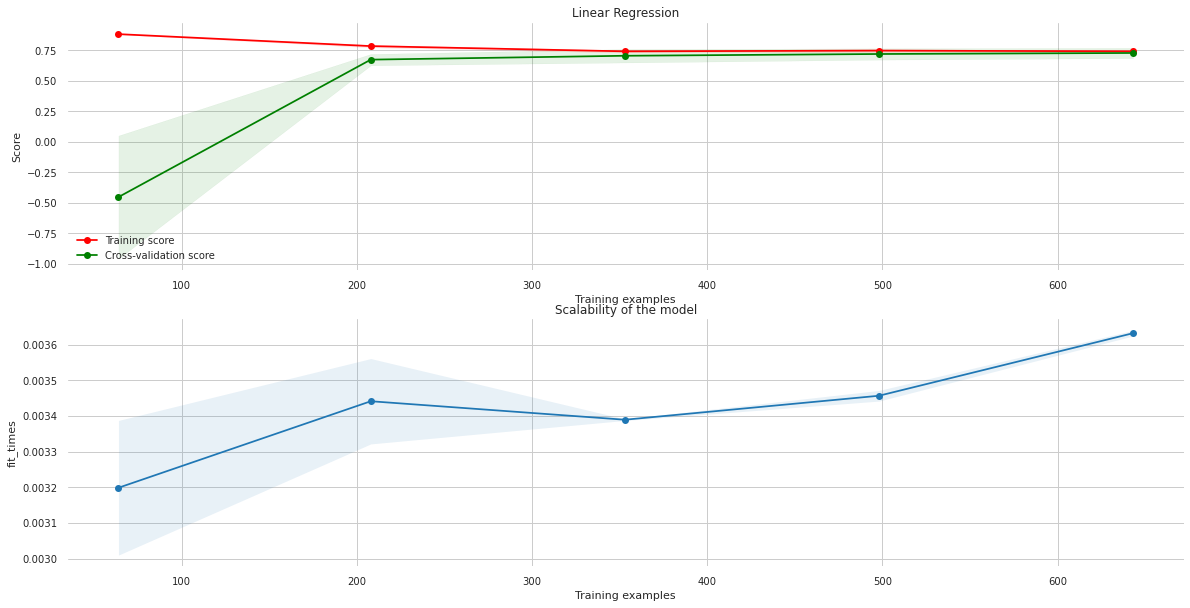

In [54]:
# Building learning curve of model
plot_learning_curve(linreg, "Linear Regression", train, target, cv=cv_train)

### 5.2 Support Vector Machines <a class="anchor" id="5.2"></a>

[Back to Table of Contents](#0.1)

**Support Vector Machines** are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training samples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new test samples to one category or the other, making it a non-probabilistic binary linear classifier. Reference [Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine).

In [55]:
# Support Vector Machines

svr = SVC()
svr_CV = GridSearchCV(svr, param_grid={'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                                       'tol': [1e-4]}, 
                      cv=cv_train, verbose=False)
svr_CV.fit(train, target)
print(svr_CV.best_params_)
acc_metrics_calc(1,svr_CV,train,test,target,target_test)

{'kernel': 'linear', 'tol': 0.0001}
target =  [0 0 0 0 0]
ytrain =  [0 0 0 1 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 0]
acc of r2_score for train = 74.18
acc of r2_score for test = 75.33
acc of acc for train = 93.92
acc of acc for test = 94.03
acc of rmse for train = 24.65
acc of rmse for test = 24.43
acc of re for train = 16.03
acc of re for test = 14.55


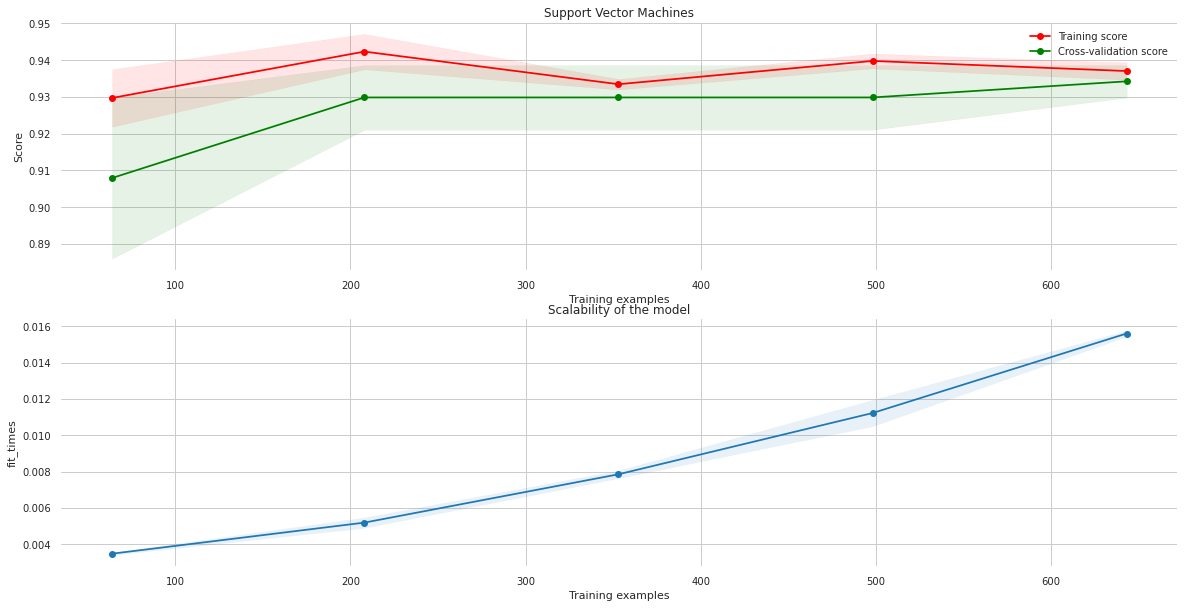

In [56]:
# Building learning curve of model
plot_learning_curve(svr, "Support Vector Machines", train, target, cv=cv_train)

### 5.3 Linear SVC <a class="anchor" id="5.3"></a>

[Back to Table of Contents](#0.1)

**Linear SVC** is a similar to SVM method. Its also builds on kernel functions but is appropriate for unsupervised learning. Reference [Wikipedia](https://en.wikipedia.org/wiki/Support-vector_machine#Support-vector_clustering_(svr).

In [57]:
# Linear SVR

linear_svc = LinearSVC()
param_grid = {'dual':[False],
              'C': np.linspace(1, 15, 15)}
linear_svc_CV = GridSearchCV(linear_svc, param_grid=param_grid, cv=cv_train, verbose=False)
linear_svc_CV.fit(train, target)
print(linear_svc_CV.best_params_)
acc_metrics_calc(2,linear_svc_CV,train,test,target,target_test)

{'C': 2.0, 'dual': False}
target =  [0 0 0 0 0]
ytrain =  [0 0 0 1 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 0]
acc of r2_score for train = 76.43
acc of r2_score for test = 75.33
acc of acc for train = 94.45
acc of acc for test = 94.03
acc of rmse for train = 23.55
acc of rmse for test = 24.43
acc of re for train = 14.63
acc of re for test = 14.55


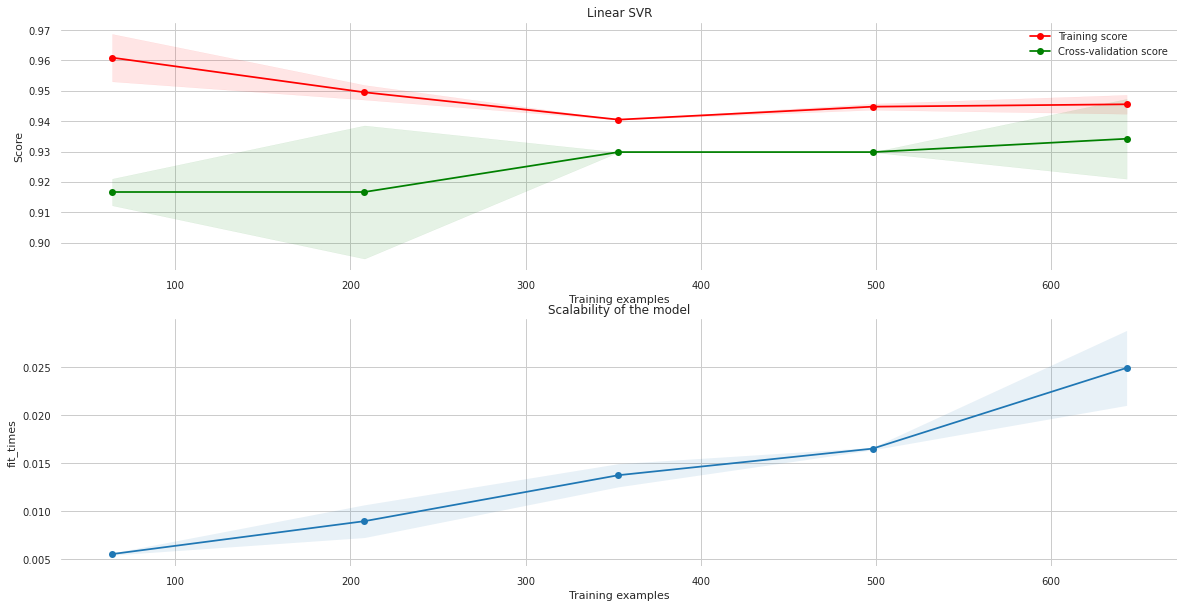

In [58]:
# Building learning curve of model
plot_learning_curve(linear_svc, "Linear SVR", train, target, cv=cv_train)

### 5.4 MLP Classifier<a class="anchor" id="5.4"></a>

[Back to Table of Contents](#0.1)

The **MLPClassifier** optimizes the squared-loss using LBFGS or stochastic gradient descent by the Multi-layer Perceptron regressor. Reference [Sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor).

Thanks to:
* https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor
* https://stackoverflow.com/questions/44803596/scikit-learn-mlpregressor-performance-cap

In [59]:
%%time
# MLPClassifier

mlp = MLPClassifier()
param_grid = {'hidden_layer_sizes': [i for i in range(2,5)],
              'solver': ['sgd'],
              'learning_rate': ['adaptive'],
              'max_iter': [1000]
              }
mlp_GS = GridSearchCV(mlp, param_grid=param_grid, cv=cv_train, verbose=False)
mlp_GS.fit(train, target)
print(mlp_GS.best_params_)
acc_metrics_calc(3,mlp_GS,train,test,target,target_test)

{'hidden_layer_sizes': 3, 'learning_rate': 'adaptive', 'max_iter': 1000, 'solver': 'sgd'}
target =  [0 0 0 0 0]
ytrain =  [0 0 0 0 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 1]
acc of r2_score for train = 68.57
acc of r2_score for test = 62.99
acc of acc for train = 92.6
acc of acc for test = 91.04
acc of rmse for train = 27.2
acc of rmse for test = 29.93
acc of re for train = 19.51
acc of re for test = 21.82
CPU times: user 10.6 s, sys: 1.17 ms, total: 10.6 s
Wall time: 10.6 s


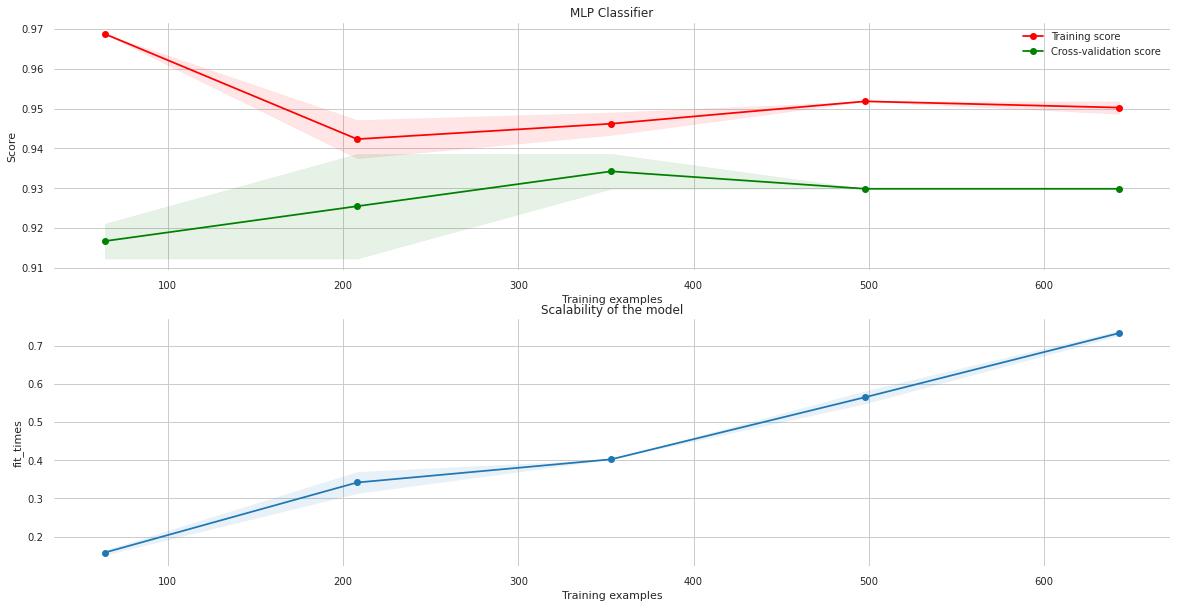

In [60]:
# Building learning curve of model
plot_learning_curve(mlp, "MLP Classifier", train, target, cv=cv_train)

### 5.5 Stochastic Gradient Descent <a class="anchor" id="5.5"></a>

[Back to Table of Contents](#0.1)

**Stochastic gradient descent** (often abbreviated **SGD**) is an iterative method for optimizing an objective function with suitable smoothness properties (e.g. differentiable or subdifferentiable). It can be regarded as a stochastic approximation of gradient descent optimization, since it replaces the actual gradient (calculated from the entire data set) by an estimate thereof (calculated from a randomly selected subset of the data). Especially in big data applications this reduces the computational burden, achieving faster iterations in trade for a slightly lower convergence rate. Reference [Wikipedia](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).

In [61]:
# Stochastic Gradient Descent

sgd = SGDClassifier(early_stopping=True)
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
sgd_CV = GridSearchCV(sgd, param_grid=param_grid, cv=cv_train, verbose=False)
sgd_CV.fit(train, target)
print(sgd_CV.best_params_)
acc_metrics_calc(4,sgd_CV,train,test,target,target_test)

{'alpha': 0.01}
target =  [0 0 0 0 0]
ytrain =  [0 0 0 1 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 1]
acc of r2_score for train = 66.33
acc of r2_score for test = 69.16
acc of acc for train = 92.07
acc of acc for test = 92.54
acc of rmse for train = 28.15
acc of rmse for test = 27.32
acc of re for train = 20.91
acc of re for test = 18.18


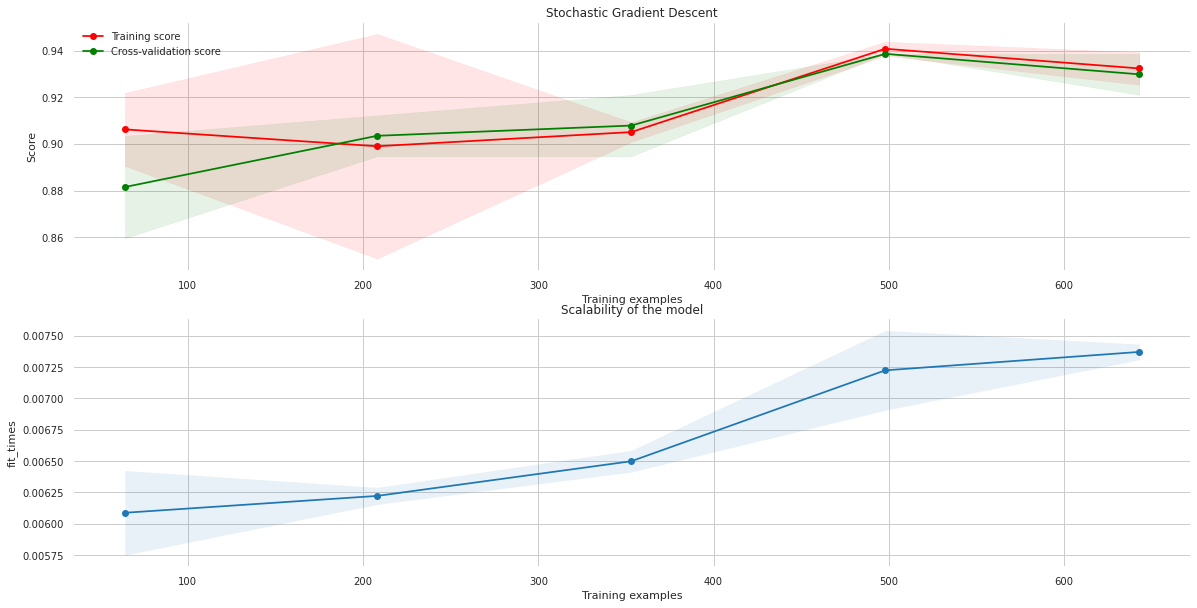

In [62]:
# Building learning curve of model
plot_learning_curve(sgd, "Stochastic Gradient Descent", train, target, cv=cv_train)

### 5.6 Decision Tree Classifier<a class="anchor" id="5.6"></a>

[Back to Table of Contents](#0.1)

This model uses a **Decision Tree** as a predictive model which maps features (tree branches) to conclusions about the target value (tree leaves). Tree models where the target variable can take a finite set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees. Reference [Wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning).

In [63]:
# Decision Tree Classifier

decision_tree = DecisionTreeClassifier()
param_grid = {'min_samples_leaf': [i for i in range(2,10)]}
decision_tree_CV = GridSearchCV(decision_tree, param_grid=param_grid, cv=cv_train, verbose=False)
decision_tree_CV.fit(train, target)
print(decision_tree_CV.best_params_)
acc_metrics_calc(5,decision_tree_CV,train,test,target,target_test)

{'min_samples_leaf': 3}
target =  [0 0 0 0 0]
ytrain =  [0 0 0 0 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 0]
acc of r2_score for train = 89.34
acc of r2_score for test = 81.5
acc of acc for train = 97.49
acc of acc for test = 95.52
acc of rmse for train = 15.84
acc of rmse for test = 21.16
acc of re for train = 6.62
acc of re for test = 10.91


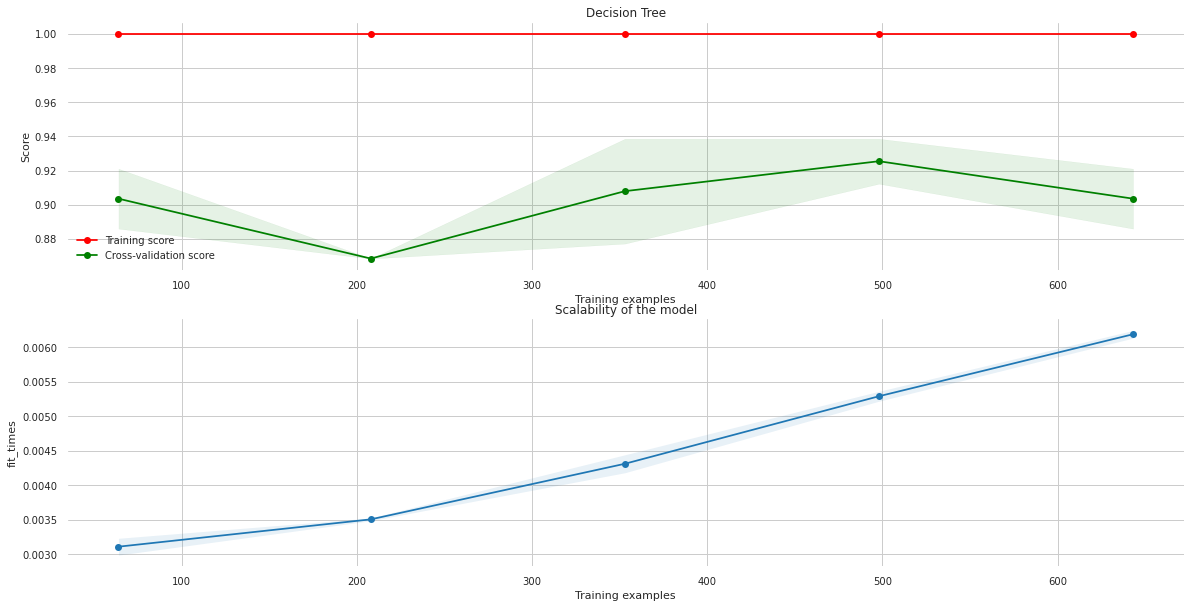

In [64]:
# Building learning curve of model
plot_learning_curve(decision_tree, "Decision Tree", train, target, cv=cv_train)

### 5.7 Random Forest <a class="anchor" id="5.7"></a>

[Back to Table of Contents](#0.1)

**Random Forest** is one of the most popular model. Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees (n_estimators= [100, 300]) at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Reference [Wikipedia](https://en.wikipedia.org/wiki/Random_forest).

In [65]:
%%time
# Random Forest
# Parameters of model (param_grid) taken from the notebook https://www.kaggle.com/morenovanton/titanic-random-forest

random_forest = RandomForestClassifier()
param_grid = {'n_estimators': [300, 400, 500, 600], 'min_samples_split': [60], 'min_samples_leaf': [20, 25, 30, 35, 40], 
              'max_features': ['auto'], 'max_depth': [5, 6, 7, 8, 9, 10], 'criterion': ['gini'], 'bootstrap': [False]}
random_forest_CV = GridSearchCV(estimator=random_forest, param_grid=param_grid, 
                             cv=cv_train, verbose=False)
random_forest_CV.fit(train, target)
print(random_forest_CV.best_params_)
acc_metrics_calc(6,random_forest_CV,train,test,target,target_test)

{'bootstrap': False, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 30, 'min_samples_split': 60, 'n_estimators': 500}
target =  [0 0 0 0 0]
ytrain =  [0 0 0 1 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 0]
acc of r2_score for train = 74.75
acc of r2_score for test = 72.24
acc of acc for train = 94.06
acc of acc for test = 93.28
acc of rmse for train = 24.38
acc of rmse for test = 25.92
acc of re for train = 15.68
acc of re for test = 16.36
CPU times: user 2min 46s, sys: 788 ms, total: 2min 47s
Wall time: 2min 47s


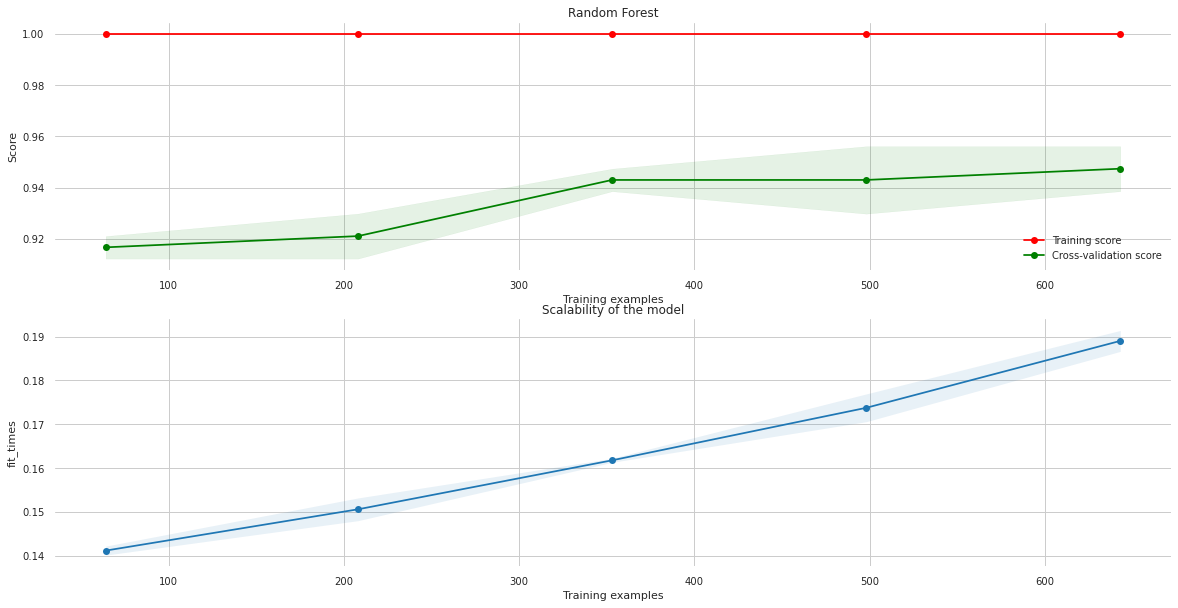

In [66]:
# Building learning curve of model
plot_learning_curve(random_forest, "Random Forest", train, target, cv=cv_train)

### 5.8 XGB Classifier<a class="anchor" id="5.8"></a>

[Back to Table of Contents](#0.1)

**XGBoost** is an ensemble tree method that apply the principle of boosting weak learners (CARTs generally) using the gradient descent architecture. XGBoost improves upon the base Gradient Boosting Machines (GBM) framework through systems optimization and algorithmic enhancements. Reference [Towards Data Science.](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d)

In [67]:
%%time
# XGBoost Classifier
xgb_clf = xgb.XGBClassifier(objective='reg:squarederror') 
parameters = {'n_estimators': [200, 300, 400], 
              'learning_rate': [0.001, 0.003, 0.005, 0.006, 0.01],
              'max_depth': [4, 5, 6]}
xgb_reg = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=cv_train).fit(trainb, targetb)
print("Best score: %0.3f" % xgb_reg.best_score_)
print("Best parameters set:", xgb_reg.best_params_)
acc_metrics_calc(7,xgb_reg,trainb,testb,targetb,target_testb)

Best score: 0.956
Best parameters set: {'learning_rate': 0.005, 'max_depth': 4, 'n_estimators': 400}
target =  [0 0 0 0 0]
ytrain =  [0 0 0 0 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 0]
acc of r2_score for train = 83.16
acc of r2_score for test = 75.33
acc of acc for train = 96.04
acc of acc for test = 94.03
acc of rmse for train = 19.91
acc of rmse for test = 24.43
acc of re for train = 10.45
acc of re for test = 14.55
CPU times: user 1min 33s, sys: 1.92 s, total: 1min 35s
Wall time: 24.9 s


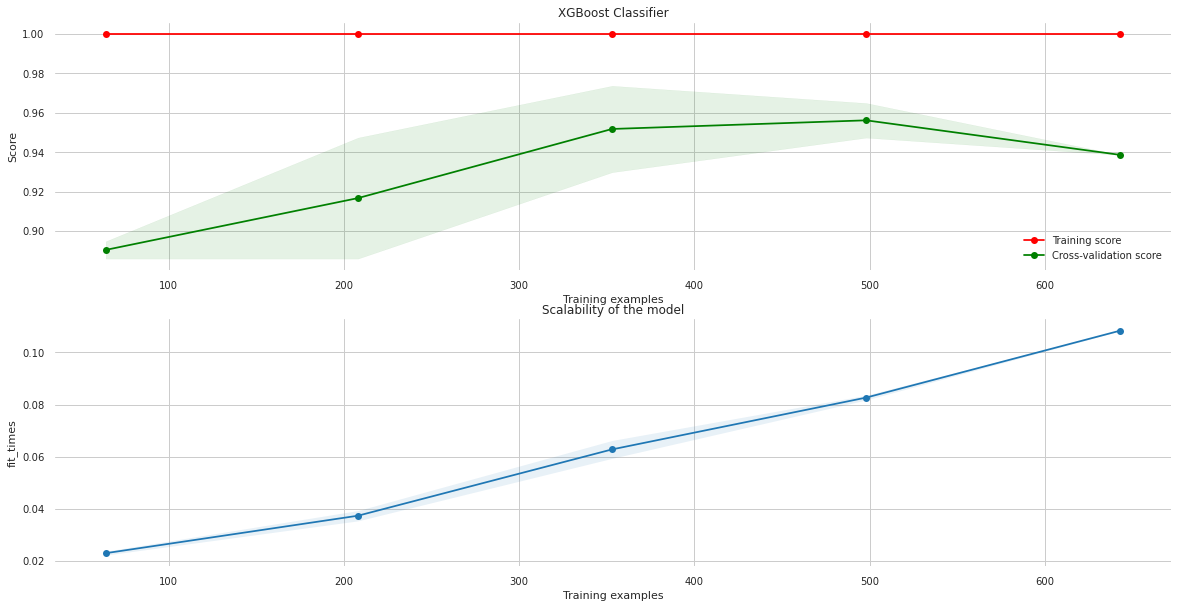

In [68]:
# Building learning curve of model
plot_learning_curve(xgb_clf, "XGBoost Classifier", trainb, targetb, cv=cv_train)

### 5.9 LGBM Classifier <a class="anchor" id="5.9"></a>

[Back to Table of Contents](#0.1)

**Light GBM** is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithms. It splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms. Also, it is surprisingly very fast, hence the word ‘Light’. Reference [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/).

In [69]:
#%% split training set to validation set
Xtrain, Xval, Ztrain, Zval = train_test_split(trainb, targetb, test_size=test_train_split_part, random_state=random_state)
modelL = lgb.LGBMClassifier(n_estimators=1000, num_leaves=50)
modelL.fit(Xtrain, Ztrain, eval_set=[(Xval, Zval)], early_stopping_rounds=50, verbose=True)

[1]	valid_0's binary_logloss: 0.595468
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.533349
[3]	valid_0's binary_logloss: 0.484585
[4]	valid_0's binary_logloss: 0.440465
[5]	valid_0's binary_logloss: 0.402959
[6]	valid_0's binary_logloss: 0.372
[7]	valid_0's binary_logloss: 0.345242
[8]	valid_0's binary_logloss: 0.321482
[9]	valid_0's binary_logloss: 0.301602
[10]	valid_0's binary_logloss: 0.285186
[11]	valid_0's binary_logloss: 0.270442
[12]	valid_0's binary_logloss: 0.256925
[13]	valid_0's binary_logloss: 0.245
[14]	valid_0's binary_logloss: 0.234811
[15]	valid_0's binary_logloss: 0.226386
[16]	valid_0's binary_logloss: 0.218149
[17]	valid_0's binary_logloss: 0.210775
[18]	valid_0's binary_logloss: 0.205729
[19]	valid_0's binary_logloss: 0.20011
[20]	valid_0's binary_logloss: 0.193932
[21]	valid_0's binary_logloss: 0.188317
[22]	valid_0's binary_logloss: 0.18519
[23]	valid_0's binary_logloss: 0.18104
[24]	valid_0's binary_logloss: 0.1801

LGBMClassifier(n_estimators=1000, num_leaves=50)

In [70]:
acc_metrics_calc(8,modelL,trainb,testb,targetb,target_testb)

target =  [0 0 0 0 0]
ytrain =  [0 0 0 0 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 0]
acc of r2_score for train = 91.58
acc of r2_score for test = 75.33
acc of acc for train = 98.02
acc of acc for test = 94.03
acc of rmse for train = 14.08
acc of rmse for test = 24.43
acc of re for train = 5.23
acc of re for test = 14.55


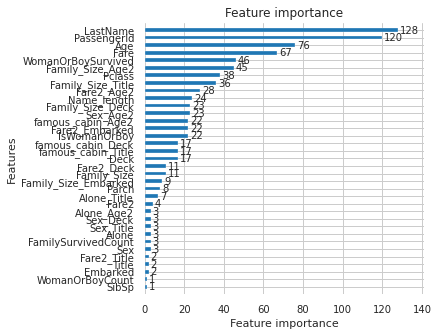

In [71]:
fig =  plt.figure(figsize = (5,5))
axes = fig.add_subplot(111)
lgb.plot_importance(modelL,ax = axes,height = 0.5)
plt.show();
plt.close()

### 5.10 Gradient Boosting Classifier<a class="anchor" id="5.10"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/kabure/titanic-eda-model-pipeline-keras-nn

**Gradient Boosting** builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes_ regression trees are fit on the negative gradient of the binomial or multinomial deviance loss function. Binary classification is a special case where only a single regression tree is induced. The features are always randomly permuted at each split. Therefore, the best found split may vary, even with the same training data and max_features=n_features, if the improvement of the criterion is identical for several splits enumerated during the search of the best split. To obtain a deterministic behaviour during fitting, random_state has to be fixed. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html).

In [72]:
# Gradient Boosting Classifier

gradient_boosting = GradientBoostingClassifier()
param_grid = {'learning_rate' : [0.001, 0.01, 0.1],
              'max_depth': [i for i in range(2,5)],
              'min_samples_leaf': [i for i in range(2,5)]}
gradient_boosting_CV = GridSearchCV(estimator=gradient_boosting, param_grid=param_grid, 
                                    cv=cv_train, verbose=False)
gradient_boosting_CV.fit(train, target)
print(gradient_boosting_CV.best_params_)
acc_metrics_calc(9,gradient_boosting_CV,train,test,target,target_test)

{'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 3}
target =  [0 0 0 0 0]
ytrain =  [0 0 0 0 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 0]
acc of r2_score for train = 86.53
acc of r2_score for test = 78.41
acc of acc for train = 96.83
acc of acc for test = 94.78
acc of rmse for train = 17.81
acc of rmse for test = 22.86
acc of re for train = 8.36
acc of re for test = 12.73


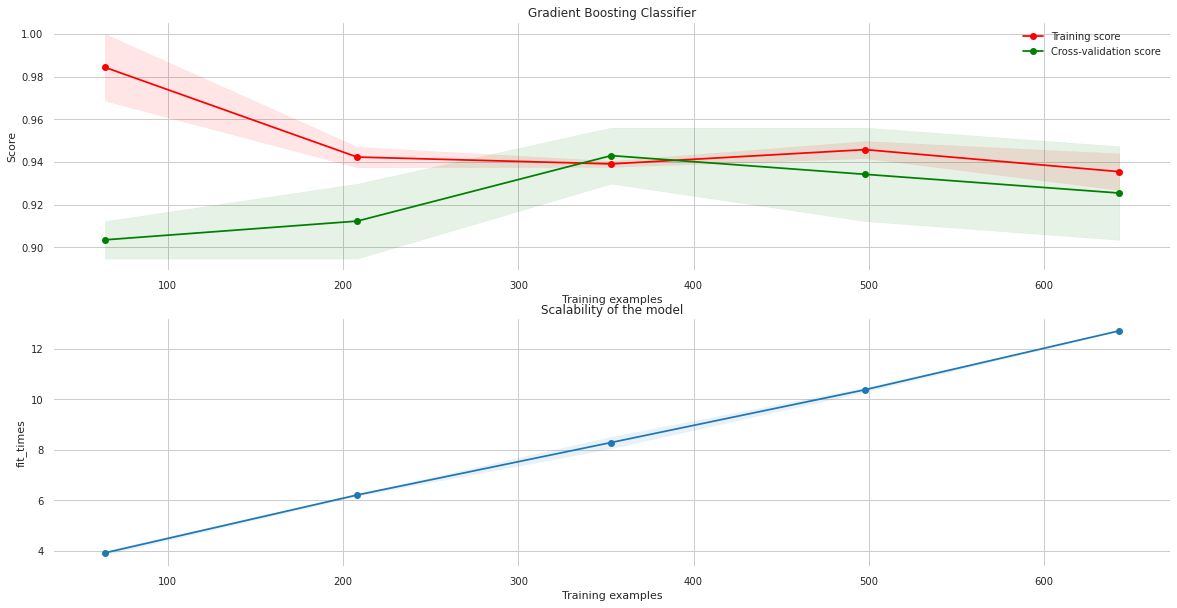

In [73]:
# Building learning curve of model
plot_learning_curve(gradient_boosting_CV, "Gradient Boosting Classifier", train, target, cv=cv_train)

### 5.11 Ridge Classifier <a class="anchor" id="5.11"></a>

[Back to Table of Contents](#0.1)

Tikhonov Regularization, colloquially known as **Ridge Classifier**, is the most commonly used regression algorithm to approximate an answer for an equation with no unique solution. This type of problem is very common in machine learning tasks, where the "best" solution must be chosen using limited data. If a unique solution exists, algorithm will return the optimal value. However, if multiple solutions exist, it may choose any of them. Reference [Brilliant.org](https://brilliant.org/wiki/ridge-regression/).

In [74]:
# Ridge Classifier

ridge = RidgeClassifier()
ridge_CV = GridSearchCV(estimator=ridge, param_grid={'alpha': np.linspace(.1, 1.5, 15)}, cv=cv_train, verbose=False)
ridge_CV.fit(train, target)
print(ridge_CV.best_params_)
acc_metrics_calc(10,ridge_CV,train,test,target,target_test)

{'alpha': 0.1}
target =  [0 0 0 0 0]
ytrain =  [0 0 0 1 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 0]
acc of r2_score for train = 71.94
acc of r2_score for test = 72.24
acc of acc for train = 93.39
acc of acc for test = 93.28
acc of rmse for train = 25.7
acc of rmse for test = 25.92
acc of re for train = 17.42
acc of re for test = 16.36


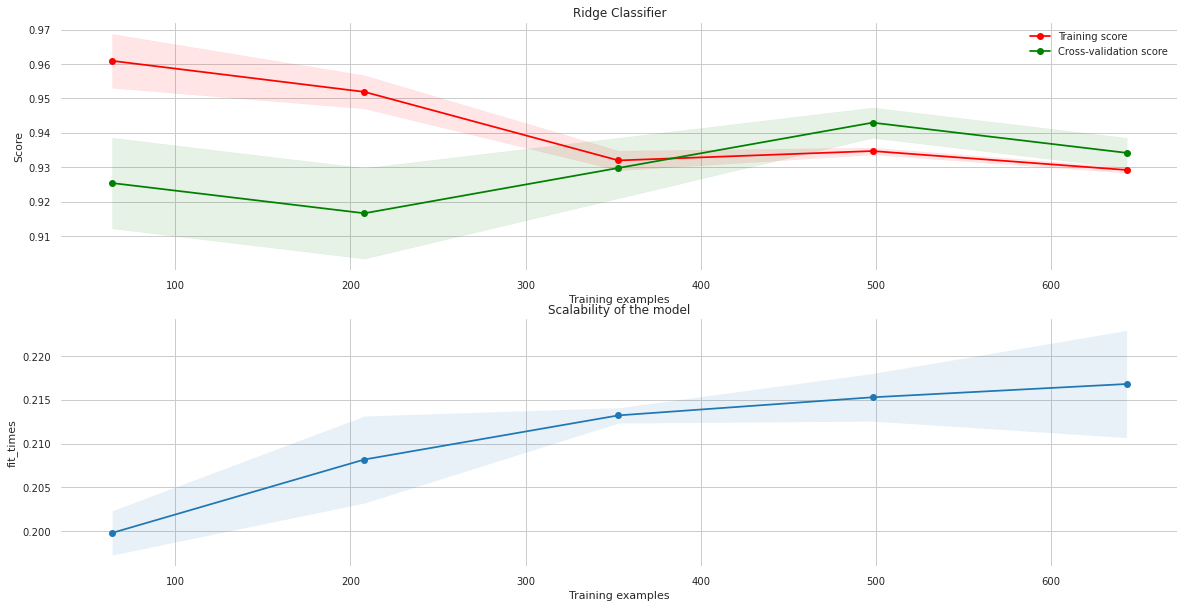

In [75]:
# Building learning curve of model
plot_learning_curve(ridge_CV, "Ridge Classifier", train, target, cv=cv_train)

### 5.12 BaggingClassifier <a class="anchor" id="5.12"></a>

[Back to Table of Contents](#0.1)

Bootstrap aggregating, also called **Bagging**, is a machine learning ensemble meta-algorithm designed to improve the stability and accuracy of machine learning algorithms used in statistical classification and regression. It also reduces variance and helps to avoid overfitting. Although it is usually applied to decision tree methods, it can be used with any type of method. Bagging is a special case of the model averaging approach. Bagging leads to "improvements for unstable procedures", which include, for example, artificial neural networks, classification and regression trees, and subset selection in linear regression. On the other hand, it can mildly degrade the performance of stable methods such as K-nearest neighbors. Reference [Wikipedia](https://en.wikipedia.org/wiki/Bootstrap_aggregating).

In [76]:
%%time
# Bagging Classifier

bagging = BaggingClassifier(base_estimator=linear_svc_CV)
param_grid={'max_features': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            'n_estimators': [3, 5, 10],
            'warm_start' : [True],
            'random_state': [random_state]}
bagging_CV = GridSearchCV(estimator=bagging, param_grid=param_grid, cv=cv_train, verbose=False)
bagging_CV.fit(train, target)
print(bagging_CV.best_params_)
acc_metrics_calc(11,bagging_CV,train,test,target,target_test)

{'max_features': 0.8, 'n_estimators': 3, 'random_state': 0, 'warm_start': True}
target =  [0 0 0 0 0]
ytrain =  [0 0 0 0 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 0]
acc of r2_score for train = 74.75
acc of r2_score for test = 75.33
acc of acc for train = 94.06
acc of acc for test = 94.03
acc of rmse for train = 24.38
acc of rmse for test = 24.43
acc of re for train = 15.68
acc of re for test = 14.55
CPU times: user 40.8 s, sys: 120 ms, total: 40.9 s
Wall time: 40.9 s


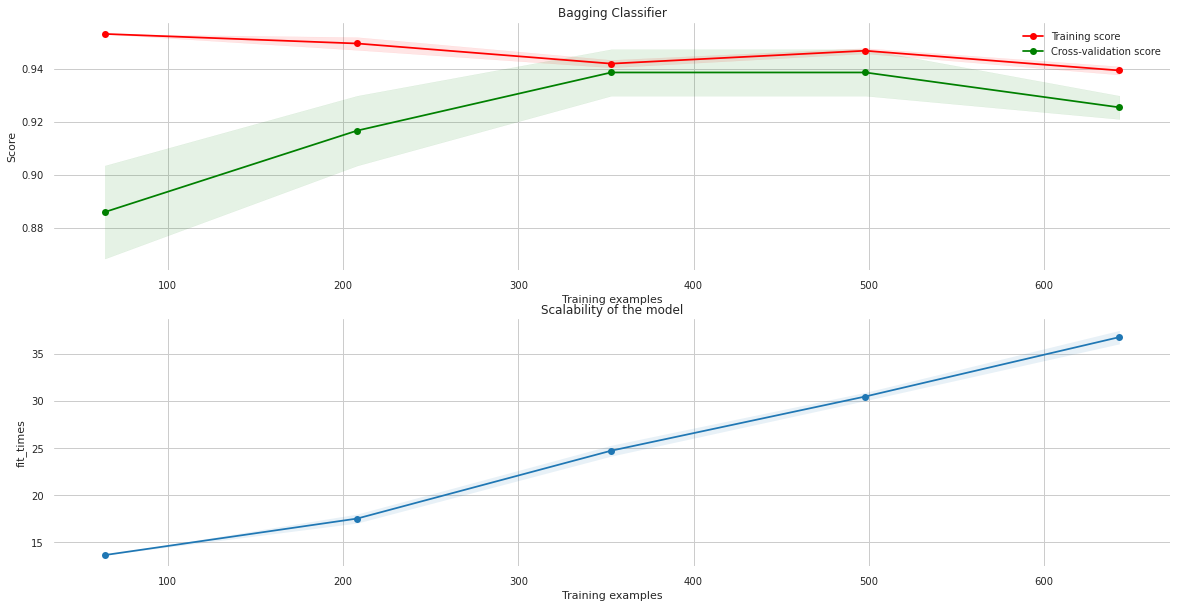

In [77]:
# Building learning curve of model
plot_learning_curve(bagging_CV, "Bagging Classifier", train, target, cv=cv_train)

### 5.13 Extra Trees Classifier <a class="anchor" id="5.13"></a>

[Back to Table of Contents](#0.1)

**ExtraTreesClassifier** implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The default values for the parameters controlling the size of the trees (e.g. max_depth, min_samples_leaf, etc.) lead to fully grown and unpruned trees which can potentially be very large on some data sets. To reduce memory consumption, the complexity and size of the trees should be controlled by setting those parameter values. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html). 

In extremely randomized trees, randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/ensemble.html#Extremely%20Randomized%20Trees).

In [78]:
# Extra Trees Classifier

etr = ExtraTreesClassifier()
etr_CV = GridSearchCV(estimator=etr, param_grid={'min_samples_leaf' : [10, 20, 30, 40, 50]}, cv=cv_train, verbose=False)
etr_CV.fit(train, target)
acc_metrics_calc(12,etr_CV,train,test,target,target_test)

target =  [0 0 0 0 0]
ytrain =  [0 0 0 1 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 0]
acc of r2_score for train = 76.99
acc of r2_score for test = 75.33
acc of acc for train = 94.58
acc of acc for test = 94.03
acc of rmse for train = 23.27
acc of rmse for test = 24.43
acc of re for train = 14.29
acc of re for test = 14.55


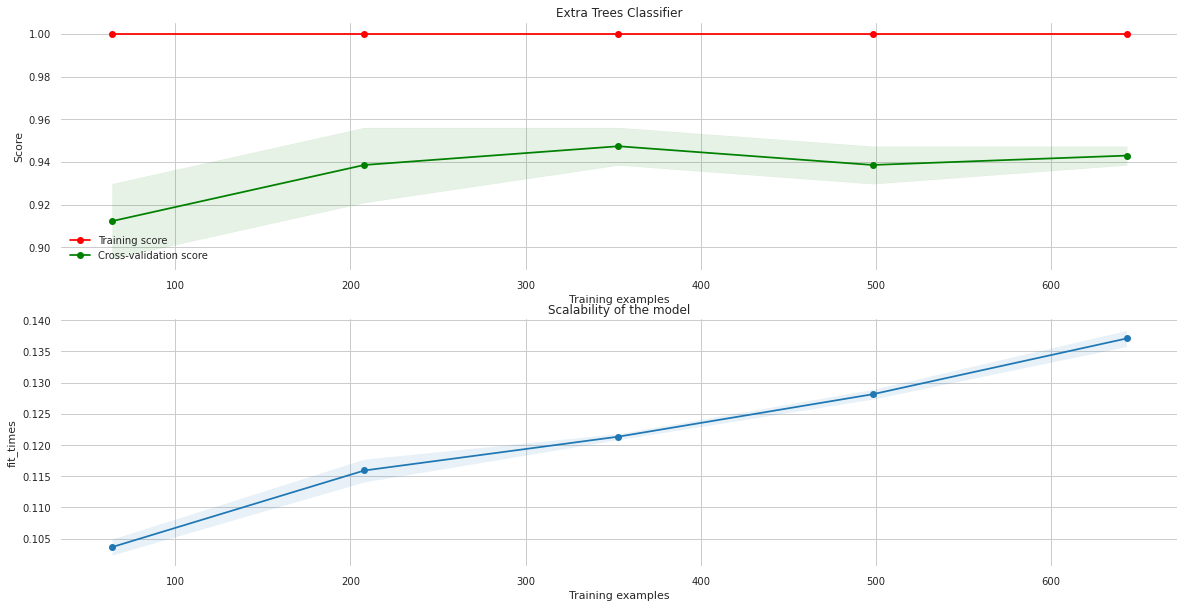

In [79]:
# Building learning curve of model
plot_learning_curve(etr, "Extra Trees Classifier", train, target, cv=cv_train)

### 5.14 AdaBoost Classifier <a class="anchor" id="5.14"></a>

[Back to Table of Contents](#0.1)

The core principle of **AdaBoost** ("Adaptive Boosting") is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. The data modifications at each so-called boosting iteration consist of applying N weights to each of the training samples. Initially, those weights are all set to 1/N, so that the first step simply trains a weak learner on the original data. For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. At a given step, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly. As iterations proceed, examples that are difficult to predict receive ever-increasing influence. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/ensemble.html#adaboost).

In [80]:
# AdaBoost Classifier

Ada_Boost = AdaBoostClassifier()
Ada_Boost_CV = GridSearchCV(estimator=Ada_Boost, param_grid={'learning_rate' : [.01, .1, .5, 1]}, cv=cv_train, verbose=False)
Ada_Boost_CV.fit(train, target)
acc_metrics_calc(13,Ada_Boost_CV,train,test,target,target_test)

target =  [0 0 0 0 0]
ytrain =  [0 0 0 1 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 0]
acc of r2_score for train = 74.18
acc of r2_score for test = 72.24
acc of acc for train = 93.92
acc of acc for test = 93.28
acc of rmse for train = 24.65
acc of rmse for test = 25.92
acc of re for train = 16.03
acc of re for test = 16.36


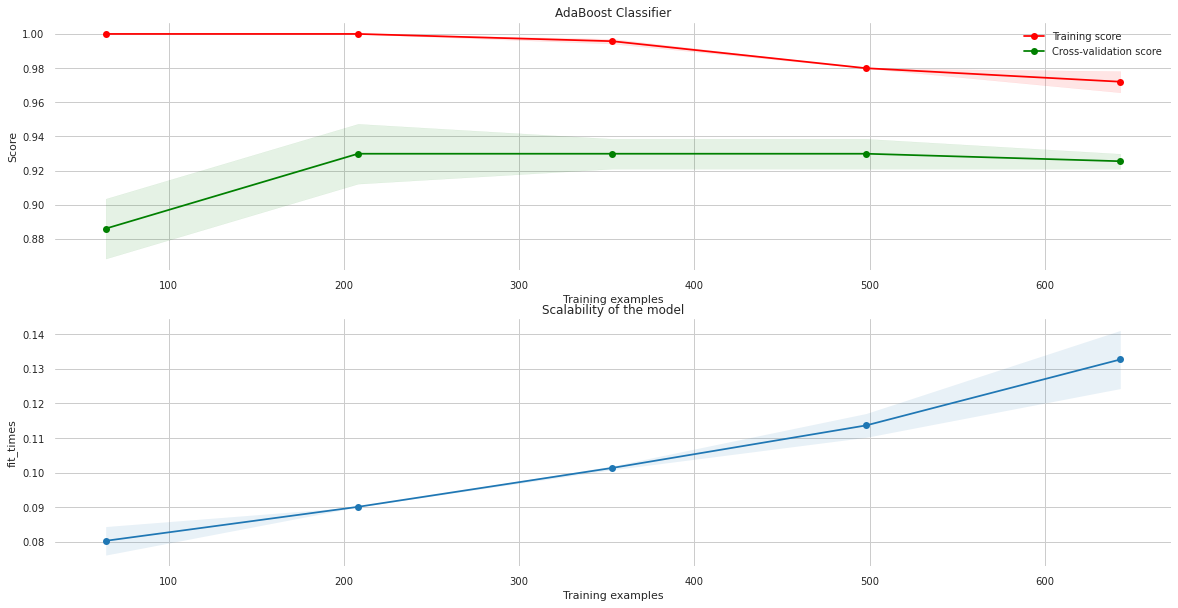

In [81]:
# Building learning curve of model
plot_learning_curve(Ada_Boost, "AdaBoost Classifier", train, target, cv=cv_train)

### 5.15 Logistic Regression <a class="anchor" id="5.15"></a>

[Back to Table of Contents](#0.1)

**Logistic Regression** is a useful model to run early in the workflow. Logistic regression measures the relationship between the categorical dependent variable (feature) and one or more independent variables (features) by estimating probabilities using a logistic function, which is the cumulative logistic distribution. Reference [Wikipedia](https://en.wikipedia.org/wiki/Logistic_regression).

In [82]:
# Logistic Regression

logreg = LogisticRegression()
logreg_CV = GridSearchCV(estimator=logreg, param_grid={'C' : [.1, .3, .5, .7, 1]}, cv=cv_train, verbose=False)
logreg_CV.fit(train, target)
acc_metrics_calc(14,logreg_CV,train,test,target,target_test)

target =  [0 0 0 0 0]
ytrain =  [0 0 0 0 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 0]
acc of r2_score for train = 71.38
acc of r2_score for test = 66.08
acc of acc for train = 93.26
acc of acc for test = 91.79
acc of rmse for train = 25.96
acc of rmse for test = 28.65
acc of re for train = 17.77
acc of re for test = 20.0


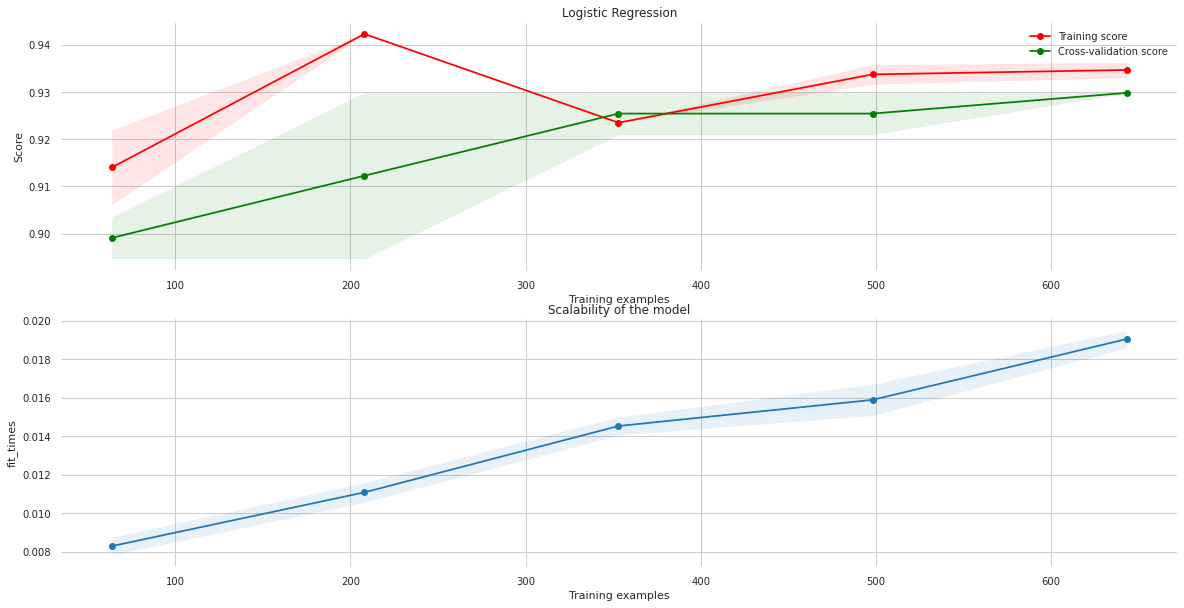

In [83]:
# Building learning curve of model
plot_learning_curve(logreg, "Logistic Regression", train, target, cv=cv_train)

### 5.16 k-Nearest Neighbors (KNN)<a class="anchor" id="5.16"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/startupsci/titanic-data-science-solutions

In pattern recognition, the **k-Nearest Neighbors algorithm** (or k-NN for short) is a non-parametric method used for classification and regression. A sample is classified by a majority vote of its neighbors, with the sample being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). Reference [Wikipedia](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm).

In [84]:
# KNN - k-Nearest Neighbors algorithm

knn = KNeighborsClassifier()
param_grid={'n_neighbors': range(2, 7)}
knn_CV = GridSearchCV(estimator=knn, param_grid=param_grid, 
                      cv=cv_train, verbose=False).fit(train, target)
print(knn_CV.best_params_)
acc_metrics_calc(15,knn_CV,train,test,target,target_test)

{'n_neighbors': 5}
target =  [0 0 0 0 0]
ytrain =  [0 0 0 0 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 0]
acc of r2_score for train = 75.87
acc of r2_score for test = 66.08
acc of acc for train = 94.32
acc of acc for test = 91.79
acc of rmse for train = 23.83
acc of rmse for test = 28.65
acc of re for train = 14.98
acc of re for test = 20.0


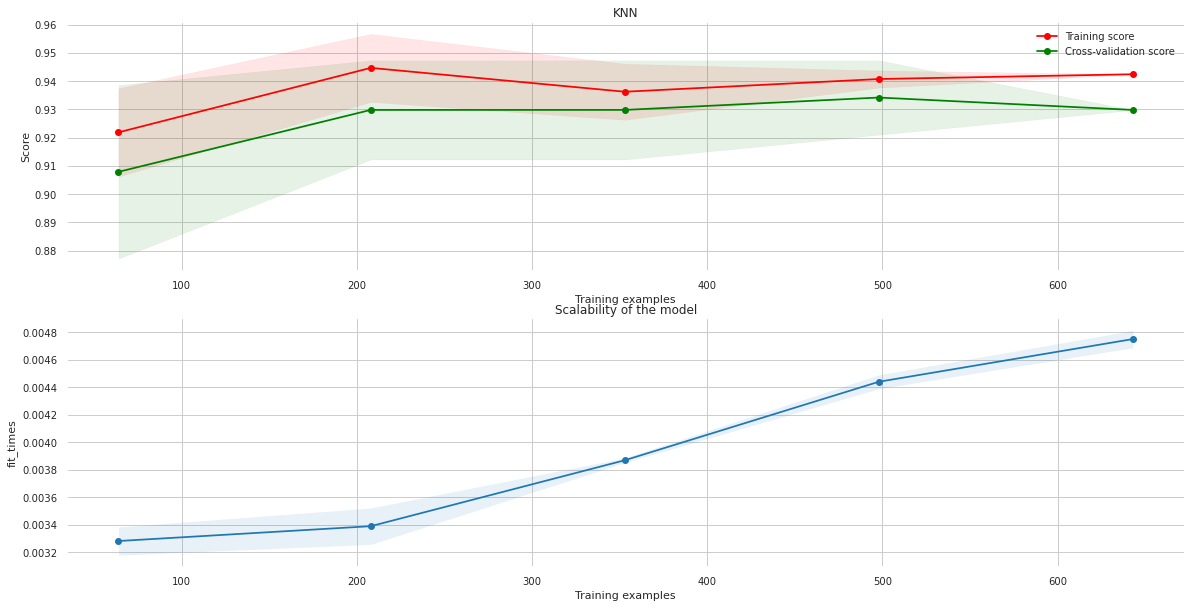

In [85]:
# Building learning curve of model
plot_learning_curve(knn, "KNN", train, target, cv=cv_train)

### 5.17 Naive Bayes <a class="anchor" id="5.17"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/startupsci/titanic-data-science-solutions

In machine learning, **Naive Bayes classifiers** are a family of simple probabilistic classifiers based on applying Bayes' theorem with strong (naive) independence assumptions between the features. Naive Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features) in a learning problem. Reference [Wikipedia](https://en.wikipedia.org/wiki/Naive_Bayes_classifier).

In [86]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
param_grid={'var_smoothing': [1e-8, 1e-9, 1e-10]}
gaussian_CV = GridSearchCV(estimator=gaussian, param_grid=param_grid, cv=cv_train, verbose=False)
gaussian_CV.fit(train, target)
print(gaussian_CV.best_params_)
acc_metrics_calc(16,gaussian_CV,train,test,target,target_test)

{'var_smoothing': 1e-08}
target =  [0 0 0 0 0]
ytrain =  [0 0 0 0 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 1]
acc of r2_score for train = 38.27
acc of r2_score for test = 32.15
acc of acc for train = 85.47
acc of acc for test = 83.58
acc of rmse for train = 38.12
acc of rmse for test = 40.52
acc of re for train = 38.33
acc of re for test = 40.0


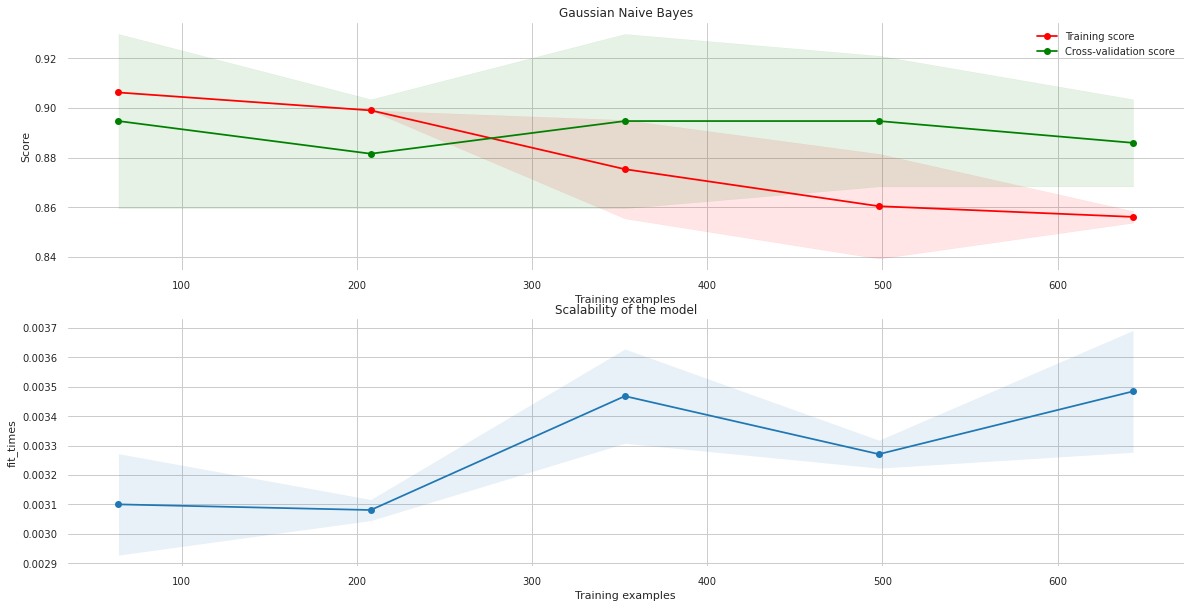

In [87]:
# Building learning curve of model
plot_learning_curve(gaussian, "Gaussian Naive Bayes", train, target, cv=cv_train)

### 5.18 Perceptron <a class="anchor" id="5.18"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/startupsci/titanic-data-science-solutions

The **Perceptron** is an algorithm for supervised learning of binary classifiers (functions that can decide whether an input, represented by a vector of numbers, belongs to some specific class or not). It is a type of linear classifier, i.e. a classification algorithm that makes its predictions based on a linear predictor function combining a set of weights with the feature vector. The algorithm allows for online learning, in that it processes elements in the training set one at a time. Reference [Wikipedia](https://en.wikipedia.org/wiki/Perceptron).

In [88]:
# Perceptron

perceptron = Perceptron()
param_grid = {'penalty': [None, 'l2', 'l1', 'elasticnet']}
perceptron_CV = GridSearchCV(estimator=perceptron, param_grid=param_grid, cv=cv_train, verbose=False)
perceptron_CV.fit(train, target)
print(perceptron_CV.best_params_)
acc_metrics_calc(17,perceptron_CV,train,test,target,target_test)

{'penalty': 'l2'}
target =  [0 0 0 0 0]
ytrain =  [0 0 0 0 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 0]
acc of r2_score for train = 60.15
acc of r2_score for test = 47.57
acc of acc for train = 90.62
acc of acc for test = 87.31
acc of rmse for train = 30.63
acc of rmse for test = 35.62
acc of re for train = 24.74
acc of re for test = 30.91


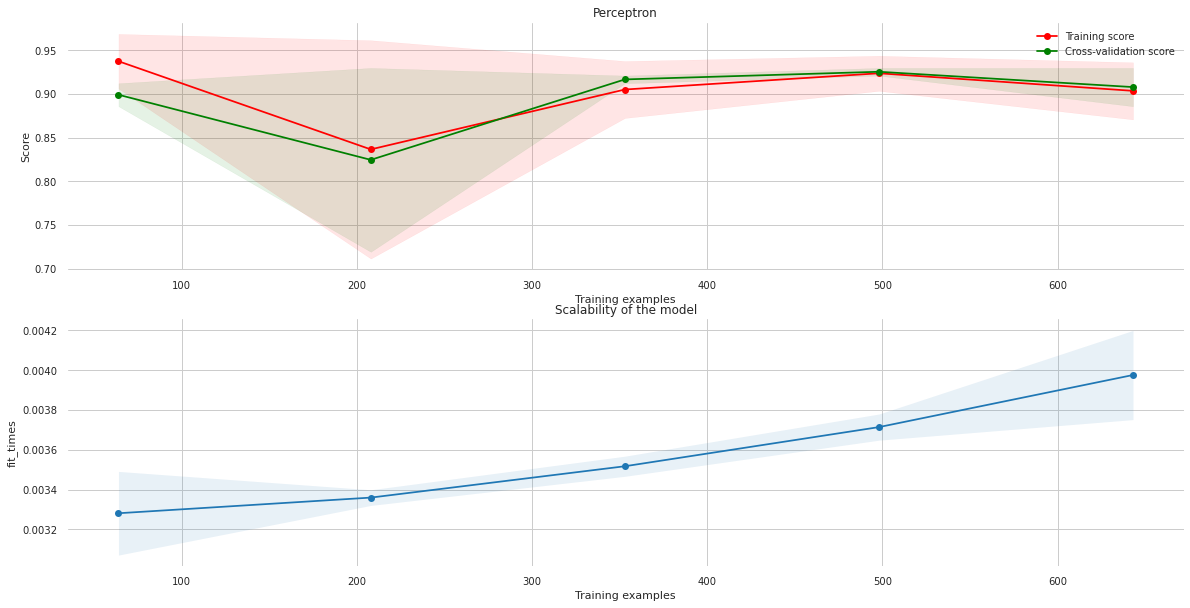

In [89]:
# Building learning curve of model
plot_learning_curve(perceptron, "Perceptron", train, target, cv=cv_train)

### 5.19 Gaussian Process Classification <a class="anchor" id="5.19"></a>

[Back to Table of Contents](#0.1)

The **GaussianProcessClassifier** implements Gaussian processes (GP) for classification purposes, more specifically for probabilistic classification, where test predictions take the form of class probabilities. GaussianProcessClassifier places a GP prior on a latent function, which is then squashed through a link function to obtain the probabilistic classification. The latent function is a so-called nuisance function, whose values are not observed and are not relevant by themselves. Its purpose is to allow a convenient formulation of the model. GaussianProcessClassifier implements the logistic link function, for which the integral cannot be computed analytically but is easily approximated in the binary case.

In contrast to the regression setting, the posterior of the latent function is not Gaussian even for a GP prior since a Gaussian likelihood is inappropriate for discrete class labels. Rather, a non-Gaussian likelihood corresponding to the logistic link function (logit) is used. GaussianProcessClassifier approximates the non-Gaussian posterior with a Gaussian based on the Laplace approximation. Reference [Sklearn documentation](https://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-classification-gpc).

In [90]:
# Gaussian Process Classification

gpc = GaussianProcessClassifier()
param_grid = {'max_iter_predict': [100, 200],
              'warm_start': [True, False],
              'n_restarts_optimizer': range(3)}
gpc_CV = GridSearchCV(estimator=gpc, param_grid=param_grid, cv=cv_train, verbose=False)
gpc_CV.fit(train, target)
print(gpc_CV.best_params_)
acc_metrics_calc(18,gpc_CV,train,test,target,target_test)

{'max_iter_predict': 100, 'n_restarts_optimizer': 0, 'warm_start': True}
target =  [0 0 0 0 0]
ytrain =  [0 0 0 1 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 0]
acc of r2_score for train = 75.87
acc of r2_score for test = 75.33
acc of acc for train = 94.32
acc of acc for test = 94.03
acc of rmse for train = 23.83
acc of rmse for test = 24.43
acc of re for train = 14.98
acc of re for test = 14.55


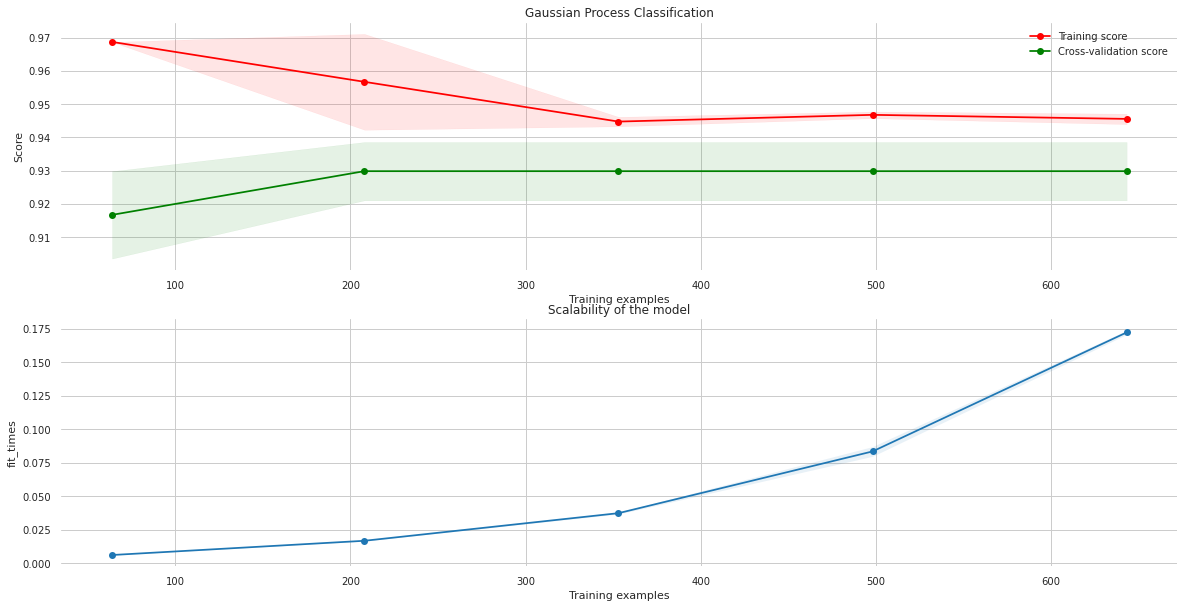

In [91]:
# Building learning curve of model
plot_learning_curve(gpc, "Gaussian Process Classification", train, target, cv=cv_train)

### 5.20 Voting Classifier <a class="anchor" id="5.20"></a>

[Back to Table of Contents](#0.1)

There is **VotingClassifier**. The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote (hard vote) or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier).

In [92]:
# Voting Classifier

Voting_ens = VotingClassifier(estimators=[('log', logreg_CV), ('mlp', mlp_GS), ('svc', linear_svc_CV)])
Voting_ens.fit(train, target)
acc_metrics_calc(19,Voting_ens,train,test,target,target_test)

target =  [0 0 0 0 0]
ytrain =  [0 0 0 0 0]
target_test = [0 0 0 1 1]
ytest = [0 0 0 1 0]
acc of r2_score for train = 71.94
acc of r2_score for test = 66.08
acc of acc for train = 93.39
acc of acc for test = 91.79
acc of rmse for train = 25.7
acc of rmse for test = 28.65
acc of re for train = 17.42
acc of re for test = 20.0


## 6. Models comparison <a class="anchor" id="6"></a>

[Back to Table of Contents](#0.1)

We can now compare our models and to choose the best one for our problem.

In [93]:
models = pd.DataFrame({
    'Model': ['Linear Regression', 'Support Vector Machines', 'Linear SVC', 
              'MLPClassifier', 'Stochastic Gradient Decent', 
              'Decision Tree Classifier', 'Random Forest',  'XGBClassifier', 'LGBMClassifier',
              'GradientBoostingClassifier', 'RidgeClassifier', 'BaggingClassifier', 'ExtraTreesClassifier', 
              'AdaBoostClassifier', 'Logistic Regression',
              'KNN', 'Naive Bayes', 'Perceptron', 'Gaussian Process Classification',
              'VotingClassifier']})

In [94]:
for x in metrics_now:
    xs = metrics_all[x]
    models[xs + '_train'] = acc_all[(x-1)*2]
    models[xs + '_test'] = acc_all[(x-1)*2+1]
    if xs == "acc":
        models[xs + '_diff'] = models[xs + '_train'] - models[xs + '_test']
models

,Model,r2_score_train,r2_score_test,acc_train,acc_test,acc_diff,rmse_train,rmse_test,re_train,re_test
0,Linear Regression,-36.93,-29.53,67.77,68.66,-0.89,56.77,55.99,85.02,76.36
1,Support Vector Machines,74.18,75.33,93.92,94.03,-0.11,24.65,24.43,16.03,14.55
2,Linear SVC,76.43,75.33,94.45,94.03,0.42,23.55,24.43,14.63,14.55
3,MLPClassifier,68.57,62.99,92.60,91.04,1.56,27.20,29.93,19.51,21.82
4,Stochastic Gradient Decent,66.33,69.16,92.07,92.54,-0.47,28.15,27.32,20.91,18.18
5,Decision Tree Classifier,89.34,81.50,97.49,95.52,1.97,15.84,21.16,6.62,10.91
6,Random Forest,74.75,72.24,94.06,93.28,0.78,24.38,25.92,15.68,16.36
7,XGBClassifier,83.16,75.33,96.04,94.03,2.01,19.91,24.43,10.45,14.55
8,LGBMClassifier,91.58,75.33,98.02,94.03,3.99,14.08,24.43,5.23,14.55
9,GradientBoostingClassifier,86.53,78.41,96.83,94.78,2.05,17.81,22.86,8.36,12.73


In [95]:
print('Prediction accuracy for models')
ms = metrics_all[metrics_now[1]] # the accuracy
models.sort_values(by=[(ms + '_test'), (ms + '_train')], ascending=False)

Prediction accuracy for models


,Model,r2_score_train,r2_score_test,acc_train,acc_test,acc_diff,rmse_train,rmse_test,re_train,re_test
5,Decision Tree Classifier,89.34,81.50,97.49,95.52,1.97,15.84,21.16,6.62,10.91
9,GradientBoostingClassifier,86.53,78.41,96.83,94.78,2.05,17.81,22.86,8.36,12.73
8,LGBMClassifier,91.58,75.33,98.02,94.03,3.99,14.08,24.43,5.23,14.55
7,XGBClassifier,83.16,75.33,96.04,94.03,2.01,19.91,24.43,10.45,14.55
12,ExtraTreesClassifier,76.99,75.33,94.58,94.03,0.55,23.27,24.43,14.29,14.55
2,Linear SVC,76.43,75.33,94.45,94.03,0.42,23.55,24.43,14.63,14.55
18,Gaussian Process Classification,75.87,75.33,94.32,94.03,0.29,23.83,24.43,14.98,14.55
11,BaggingClassifier,74.75,75.33,94.06,94.03,0.03,24.38,24.43,15.68,14.55
1,Support Vector Machines,74.18,75.33,93.92,94.03,-0.11,24.65,24.43,16.03,14.55
6,Random Forest,74.75,72.24,94.06,93.28,0.78,24.38,25.92,15.68,16.36


In [96]:
pd.options.display.float_format = '{:,.2f}'.format

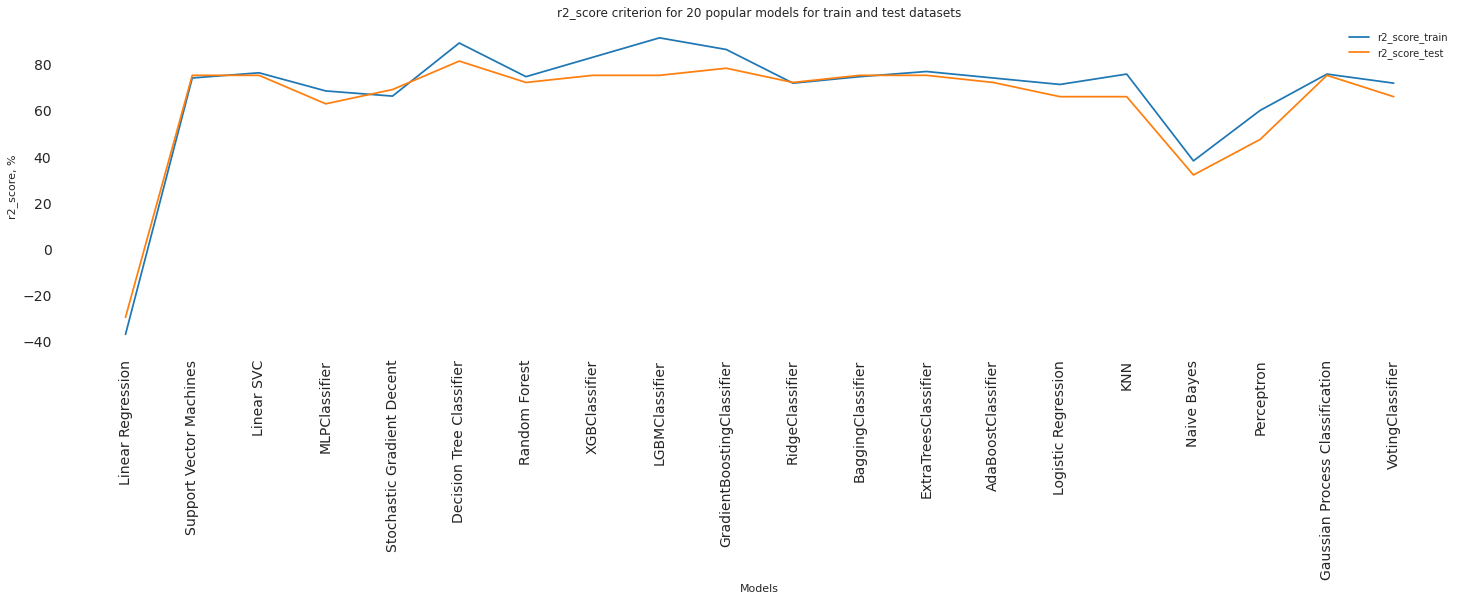

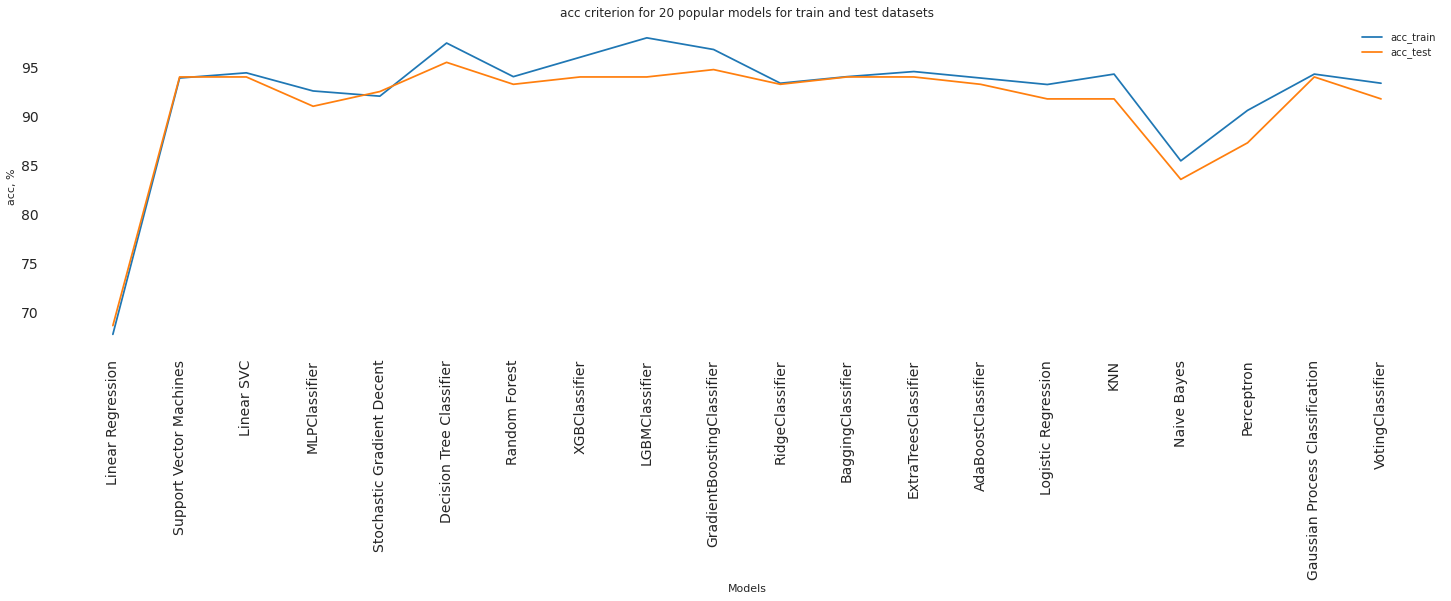

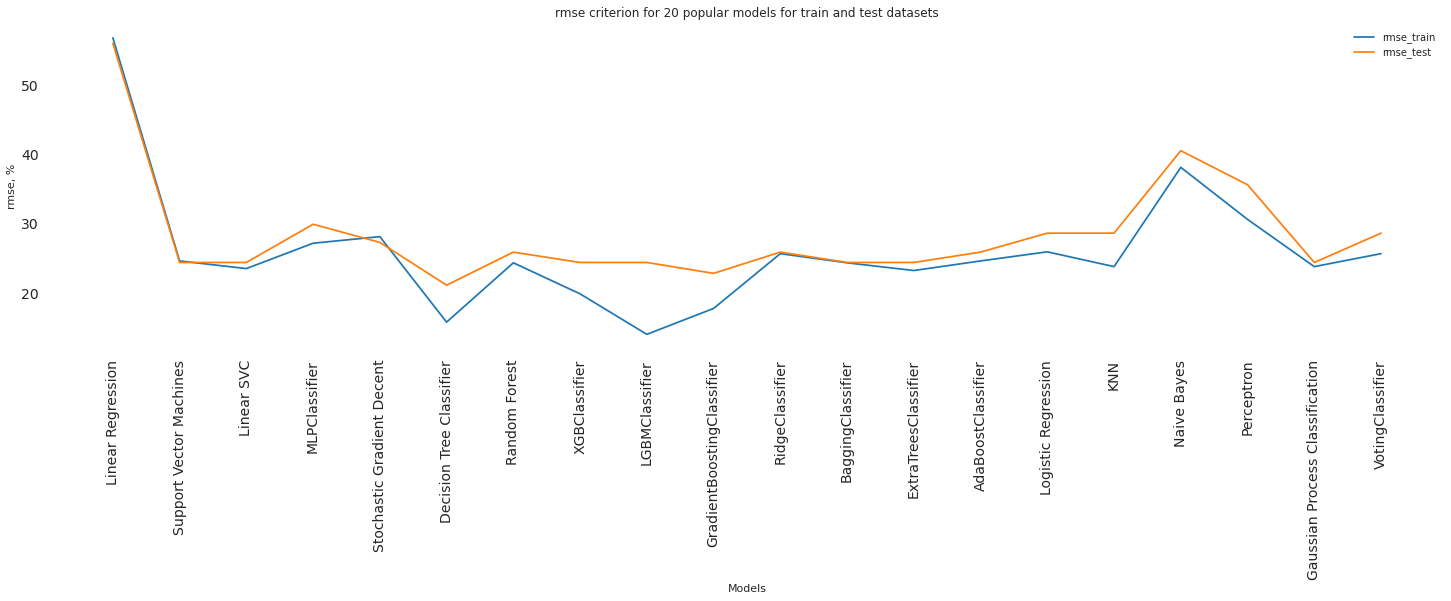

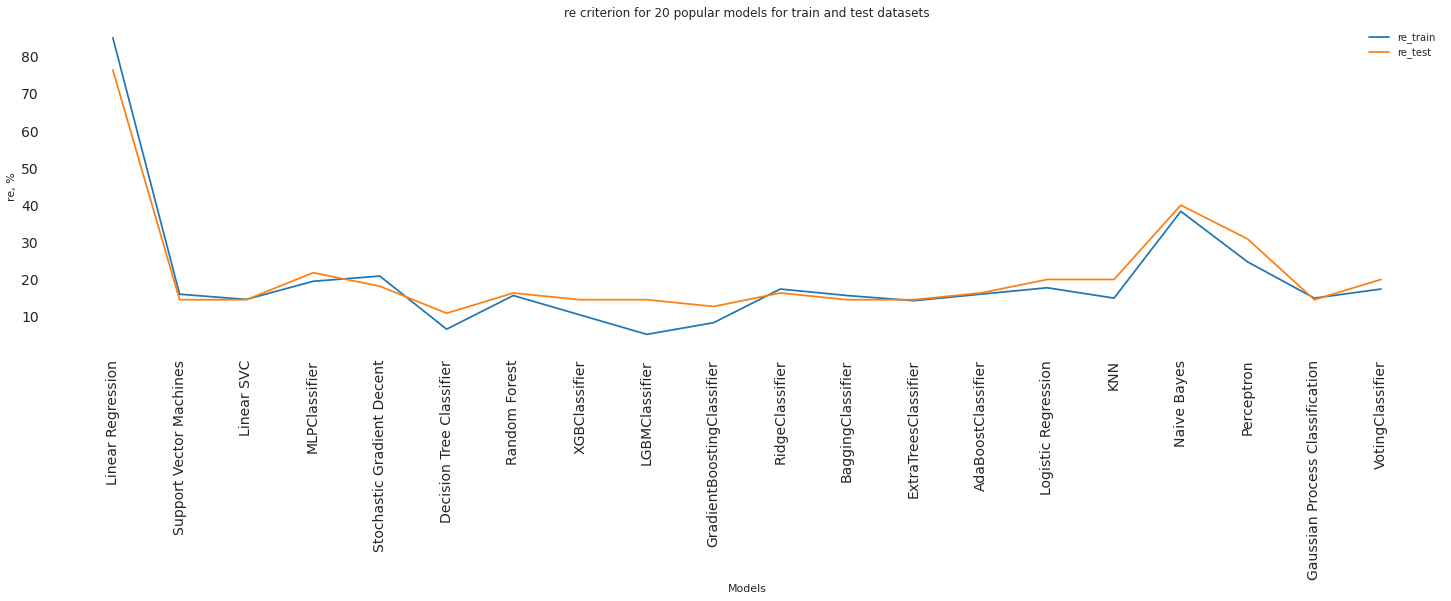

In [97]:
for x in metrics_now:   
    # Plot
    xs = metrics_all[x]
    xs_train = metrics_all[x] + '_train'
    xs_test = metrics_all[x] + '_test'
    plt.figure(figsize=[25,6])
    xx = models['Model']
    plt.tick_params(labelsize=14)
    plt.plot(xx, models[xs_train], label = xs_train)
    plt.plot(xx, models[xs_test], label = xs_test)
    plt.legend()
    plt.title(str(xs) + ' criterion for ' + str(num_models) + ' popular models for train and test datasets')
    plt.xlabel('Models')
    plt.ylabel(xs + ', %')
    plt.xticks(xx, rotation='vertical')
    plt.show()

In [98]:
# Choose the number of metric by which the best models will be determined =>  {1 : 'r2_score', 2 : 'relative_error', 3 : 'rmse'}
metrics_main = 2
xs = metrics_all[metrics_main]
xs_train = metrics_all[metrics_main] + '_train'
xs_test = metrics_all[metrics_main] + '_test'
print('The best models by the',xs,'criterion:')
direct_sort = False if (metrics_main >= 2) else True
models_sort = models.sort_values(by=[xs_test, xs_train], ascending=direct_sort)

The best models by the acc criterion:


In [99]:
# Selection the best models except VotingClassifier
models_sort = models_sort[models_sort.Model != 'VotingClassifier']
models_best = models_sort[(models_sort.acc_diff < 5) & (models_sort.acc_train > 90)]
models_best[['Model', ms + '_train', ms + '_test', 'acc_diff']].sort_values(by=['acc_test'], ascending=False)

,Model,acc_train,acc_test,acc_diff
5,Decision Tree Classifier,97.49,95.52,1.97
9,GradientBoostingClassifier,96.83,94.78,2.05
2,Linear SVC,94.45,94.03,0.42
11,BaggingClassifier,94.06,94.03,0.03
18,Gaussian Process Classification,94.32,94.03,0.29
1,Support Vector Machines,93.92,94.03,-0.11
12,ExtraTreesClassifier,94.58,94.03,0.55
7,XGBClassifier,96.04,94.03,2.01
8,LGBMClassifier,98.02,94.03,3.99
6,Random Forest,94.06,93.28,0.78


## 7. Prediction <a class="anchor" id="7"></a>

[Back to Table of Contents](#0.1)

In [100]:
models_pred = pd.DataFrame(models_best.Model, columns = ['Model'])
N_best_models = len(models_best.Model)

You should copy the code here from the appropriate section to prepare one of the best models on the entire training dataset train0

In [101]:
def model_fit(name_model,train,target):
    # Fitting name_model (from 20 options) for giver train and target
    # You can optionally add hyperparameters optimization in any model
    if name_model == 'LGBMClassifier':
        Xtrain, Xval, Ztrain, Zval = train_test_split(train, target, test_size=test_train_split_part, random_state=random_state)
        model = lgb.LGBMClassifier(n_estimators=1000)
        model.fit(Xtrain, Ztrain, eval_set=[(Xval, Zval)], early_stopping_rounds=50, verbose=False)
                
    else:
        param_grid={}
        
        if name_model == 'Linear Regression':
            model_clf = LinearRegression()
            
        elif name_model == 'Support Vector Machines':
            model_clf = SVC()
            param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'tol': [1e-4]}
            
        elif name_model == 'Linear SVC':
            model_clf = LinearSVC()
            param_grid = {'dual':[False],
                          'C': np.linspace(1, 15, 15)}
            
        elif name_model == 'MLPClassifier':
            model_clf = MLPClassifier()
            param_grid = {'hidden_layer_sizes': [i for i in range(2,5)],
                          'solver': ['sgd'],
                          'learning_rate': ['adaptive'],
                          'max_iter': [1000]
                          }

        elif name_model == 'Stochastic Gradient Decent':
            model_clf = SGDClassifier(early_stopping=True)
            param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}

        elif name_model == 'Decision Tree Classifier':
            model_clf = DecisionTreeClassifier()
            param_grid = {'min_samples_leaf': [i for i in range(2,10)]}

        elif name_model == 'Random Forest':
            model_clf = RandomForestClassifier()
            param_grid = {'n_estimators': [300, 400, 500, 600], 'min_samples_split': [60], 'min_samples_leaf': [20, 25, 30, 35, 40], 
                          'max_features': ['auto'], 'max_depth': [5, 6, 7, 8, 9, 10], 'criterion': ['gini'], 'bootstrap': [False]}

        elif name_model == 'XGBClassifier':
            model_clf = xgb.XGBClassifier(objective='reg:squarederror') 
            param_grid = {'n_estimators': [200, 300, 400], 
                          'learning_rate': [0.001, 0.003, 0.005, 0.006, 0.01],
                          'max_depth': [4, 5, 6]}
                        
        elif name_model == 'GradientBoostingClassifier':
            model_clf = GradientBoostingClassifier()
            param_grid = {'learning_rate' : [0.001, 0.01, 0.1],
                          'max_depth': [i for i in range(2,5)],
                          'min_samples_leaf': [i for i in range(2,5)]}

        elif name_model == 'RidgeClassifier':
            model_clf = RidgeClassifier()
            param_grid={'alpha': np.linspace(.1, 1.5, 15)}

        elif name_model == 'BaggingClassifier':
            model_base_estimator = GridSearchCV(LinearSVC(), param_grid={'dual':[False], 'C': np.linspace(1, 15, 15)}, 
                                            cv=cv_train, verbose=False)
            model_base_estimator.fit(train, target)
            model_clf = BaggingClassifier(base_estimator=model_base_estimator)
            param_grid={'max_features': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                        'n_estimators': [3, 5, 10],
                        'warm_start' : [True],
                        'random_state': [random_state]}

        elif name_model == 'ExtraTreesClassifier':
            model_clf = ExtraTreesClassifier()
            param_grid={'min_samples_leaf' : [10, 20, 30, 40, 50]}

        elif name_model == 'AdaBoostClassifier':
            model_clf = AdaBoostClassifier()
            param_grid={'learning_rate' : [.01, .1, .5, 1]}

        elif name_model == 'Logistic Regression':
            model_clf = LogisticRegression()
            param_grid={'C' : [.1, .3, .5, .7, 1]}

        elif name_model == 'KNN':
            model_clf = KNeighborsClassifier()
            param_grid={'n_neighbors': range(2, 7)}

        elif name_model == 'Naive Bayes':
            model_clf = GaussianNB()
            param_grid={'var_smoothing': [1e-8, 1e-9, 1e-10]}

        elif name_model == 'Perceptron':
            model_clf = Perceptron()
            param_grid = {'penalty': [None, 'l2', 'l1', 'elasticnet']}
            
        elif name_model == 'Gaussian Process Classification':
            model_clf = GaussianProcessClassifier()
            param_grid = {'max_iter_predict': [100, 200],
                          'warm_start': [True, False],
                          'n_restarts_optimizer': range(3)}
            
        model = GridSearchCV(model_clf, param_grid=param_grid, cv=cv_train, verbose=False)
        model.fit(train, target)
        
    return model

In [102]:
for i in range(N_best_models):
    name_model = models_best.iloc[i]['Model']
    if (name_model == 'LGBMClassifier') or (name_model == 'XGBClassifier'):
        # lgboosting model
        model = model_fit(name_model,train0b,target0)
        acc_metrics_calc_pred(i,model,name_model,train0b,test0b,target0)
    else:
        # model from Sklearn
        model = model_fit(name_model,train0,target0)
        acc_metrics_calc_pred(i,model,name_model,train0,test0,target0)

**********
Decision Tree Classifier
target =  [0 1 1 1 0 0 0 0 1 1 1 1 0 0 0]
ytrain =  [0 1 1 1 0 0 0 0 1 1 1 1 0 0 1]
ytest = [0 0 0 0 1 0 1 0 1 0 0 0 1 0 1]
acc of r2_score for train = 83.87
acc of acc for train = 96.18
acc of rmse for train = 19.53
acc of re for train = 9.94
**********
GradientBoostingClassifier
target =  [0 1 1 1 0 0 0 0 1 1 1 1 0 0 0]
ytrain =  [0 1 1 1 0 0 0 0 1 1 1 1 0 0 1]
ytest = [0 0 0 0 1 0 1 0 0 0 0 0 1 0 1]
acc of r2_score for train = 73.9
acc of acc for train = 93.83
acc of rmse for train = 24.85
acc of re for train = 16.08
**********
LGBMClassifier
target =  [0 1 1 1 0 0 0 0 1 1 1 1 0 0 0]
ytrain =  [0 1 1 1 0 0 0 0 1 1 1 1 0 0 1]
ytest = [0 0 0 0 1 0 1 0 1 0 0 0 1 0 1]
acc of r2_score for train = 96.68
acc of acc for train = 99.21
acc of rmse for train = 8.86
acc of re for train = 2.05
**********
XGBClassifier
target =  [0 1 1 1 0 0 0 0 1 1 1 1 0 0 0]
ytrain =  [0 1 1 1 0 0 0 0 1 1 1 1 0 0 1]
ytest = [0 1 0 0 1 0 1 0 1 0 0 0 1 0 1]
acc of r2_score for 

In [103]:
for x in metrics_now:
    xs = metrics_all[x]
    models_pred[xs + '_train'] = acc_all_pred[(x-1)]
models_pred[['Model', 'acc_train']].sort_values(by=['acc_train'], ascending=False)

,Model,acc_train
8,LGBMClassifier,99.21
5,Decision Tree Classifier,96.18
15,KNN,95.51
7,XGBClassifier,95.06
18,Gaussian Process Classification,94.73
1,Support Vector Machines,94.61
12,ExtraTreesClassifier,94.39
11,BaggingClassifier,94.28
2,Linear SVC,94.16
9,GradientBoostingClassifier,93.83


I hope you find this kernel useful and enjoyable.

Your comments and feedback are most welcome.

[Go to Top](#0)